# Developing a State-of-the-Art Interpreter Model for Sign Language Communication
Contributors: Shubham Khandale, Allen Lau, Sumaiya Uddin

Source Code: https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-signlanguageclassification.git

Project Workspace Setup: Run /src/data/make_dataset.py to download necessary data to execute this notebook.

Table of Contents:
1. [Abstract](#abstract)
2. [Introduction](#introduction)
3. [Background](#background)
4. [Data](#data)
5. [Methods](#methods)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)
8. [Attribution](#attribution)
9. [Bibliography](#bibliography)
10. [Appendix](#appendix)


Libraries

In [98]:
#importing libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import uniform

import pickle
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

from tqdm import tqdm

from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

## Abstract <a class="anchor" id="abstract"></a>

Clear and effective communication is a vital component of society. However, for individuals who rely on sign language, interacting with those who are unfamiliar with this mode of communication can be a difficult task. The development of a model capable of receiving a video stream from a camera and accurately classifying the signed letters can prove to be an invaluable tool. This technology can be utilized in various settings, including hospitals, schools, and government offices, to facilitate seamless communication and eliminate any potential communication barriers.

This notebook outlines the process of identifying the best models and features to accurately and quickly classify hand signs in a live setting, where the chosen models are divided into non-deep learning and deep learning approaches. The best non-deep learning approach is identified as a Stacking Ensemble Classifier, consisting of Logistic Regression, Support Vector Machine, Random Forest, and XGBoost estimators and a Logistic Regression meta-estimator. The features to train this ensemble model are the 23 components resulted from Linear Discriminant Analysis on the images' 784 pixel feature arrays and the first 30 principal components of the derived histogram of oriented gradients features. The best deep learning approach is identified as a convolutional neural network trained on 224 x 224 images with hand landmarks plotted onto the images. 

## Introduction <a class="anchor" id="introduction"></a>

## Background <a class="anchor" id="background"></a>

## Data <a class="anchor" id="data"></a>

The Sign Language MNIST dataset ([Kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist))  will be used for developing the Sign Language Interpreter model. It is structured as a CSV format with rows containing flattened images of pixel intensity values and its associated letter label. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z, which require motion and will not be explored in this project). The training data (27,455 instances) and test data (7172 cases) are around half the size of the standard MNIST but otherwise identical, with a header row of label, pixel1, pixel2,...pixel784 representing a single 28x28 pixel image with grayscale values ranging from 0-255.

In [9]:
#function for loading the sign language mnist dataset pickle file, generated from /src/data/make_dataset.py
def load_sign_minist(path):
    #load defined pickle file and return dat 
    with open(path,'rb') as f:
        data = pickle.load(f)
    return data

#Function to return a dictionary of numeric labels to letters 
def get_label_dict(y):
    #letters
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
    #numbers 
    y = pd.Series(y,dtype=int)
    numbers = sorted(list(y.unique()))
    #dictionary of labels 
    return dict(zip(numbers,letters))

#function to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')
    
#load dataset
X_train,y_train,X_test,y_test = load_sign_minist('../data/external/sign_mnist.pkl')

#get labels dictionary
label_dict = get_label_dict(y_train)

#list of letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

        

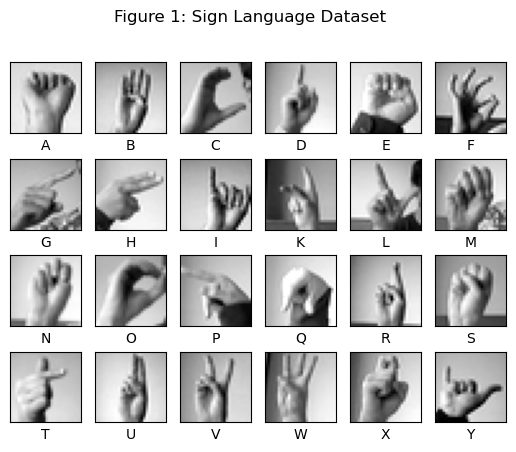

In [10]:
def visualize_data(x,y,labels_dict):
    #visualization of dataset 
    fig, ax = plt.subplots(4,6)
    ax = ax.ravel()
    pos = 0 
    #loop through each label in dataset 
    for label in range(0,26):
        #if label is not included in dataset 
        if label in [9,25]:
            continue
        #find first index of label
        idx = find_indices(y,label)[0][0]
        #display first found image 
        ax[pos].imshow(x[idx],cmap='gray')
        #set x label as dataset label
        ax[pos].set(xlabel=labels_dict[label])
        #do not show ticks 
        ax[pos].set_xticks([])
        ax[pos].set_yticks([])
        #increment for subplotting 
        pos+=1
    plt.suptitle('Figure 1: Sign Language Dataset')
    plt.close()
    return fig

#visualizing examples from the data set
fig = visualize_data(X_train,y_train,label_dict)
fig

Fig. 1 displays example images for each letter in the dataset. As described above, it is observed that each image is a grayscale, 28x28 image. The labels for this classification problem includes letters A - Z, excluding J and Z since these signs are motioned. The images consist of 784 pixel intensity values ranging from 0 - 255, where 0 is black and 255 is white, which are the features being used for machine learning. 

The letters A, E, M, N, and S are similar. It is expected that models may have difficulty differentiating these signs. In contrast, letters like L, O, and Y are very different from the other classes; therefore, it is expected that the models would perform better classifying these letters. 

### Exploratory Data Analysis

The average image, created by taking the average values of each pixel across all images in the dataset, is plotted below. Additionally, the variance image, created by taking the variance of values for each pixel across all images, is plotted. 

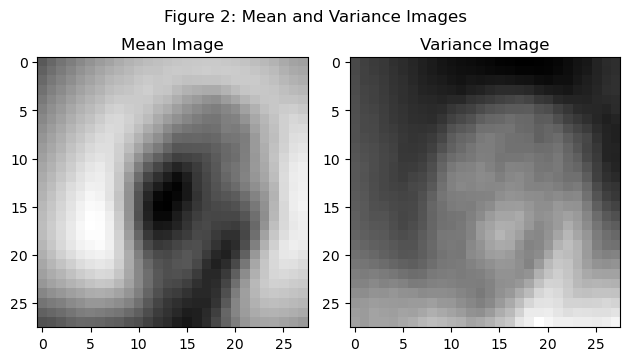

In [11]:
def mean_var_image(x):
    #create subplot
    fig, ax = plt.subplots(1, 2)
    ax = ax.ravel()
    #reshaping arrays and finding the mean and variance of each picel 
    x = x.reshape(x.shape[0], -1)
    mean_img = np.mean(x, axis=0)
    var_img = np.var(x, axis=0)
    #plotting mean image
    ax[0].imshow(mean_img.reshape(28, 28), cmap='gray')
    ax[0].set_title('Mean Image')
    #plotting variance image
    ax[1].imshow(var_img.reshape(28, 28), cmap='gray')
    ax[1].set_title('Variance Image')
    
    plt.suptitle('Figure 2: Mean and Variance Images',y=0.85)
    plt.tight_layout()
    plt.close()
    return fig

#Plotting mean and varience image
mean_var_image(X_train)

Figure 2 displays the Mean Image, which illustrates the average positioning of our hands being centered with there being a small border on all sides. The background is generally white, however there are some differences in the far corners of the images. The Variance Image shows that the background of our images are not consistently the same. 

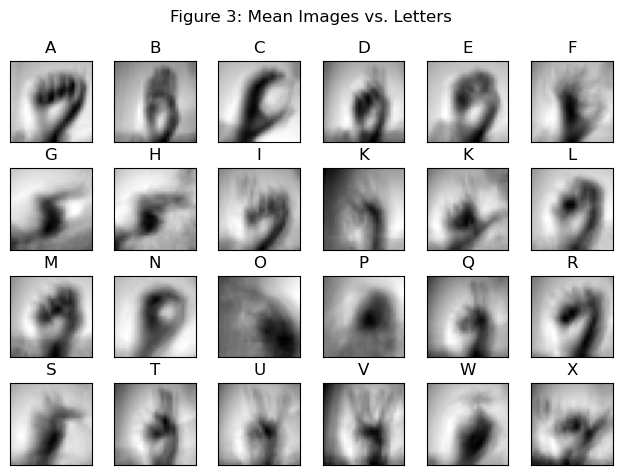

In [12]:
#Function to plot the average and variance images for each class in a dataset.
def plot_mean_images(X, y, label_dict):
    # Grouping the training data by label and calculate the mean of each pixel across all observations with the same label
    mean_images = []
    for label in np.unique(y):
        label_images = X[y == label]
        mean_image = np.mean(label_images, axis=0)
        mean_images.append(mean_image)

    # Plotting the average image for each class
    fig, ax = plt.subplots(4, 6)
    ax = ax.ravel()
    pos = 0
    for i, mean_image in enumerate(mean_images):
        if i == 9:
            i+=1
        ax[pos].imshow(mean_image, cmap='gray')
        label = label_dict[i]  # Retrieve the corresponding letter using the label index
        ax[pos].set_title(label)
        ax[pos].set_xticks([])
        ax[pos].set_yticks([])
        pos+=1

    plt.suptitle('Figure 3: Mean Images vs. Letters')
    plt.tight_layout()
    plt.show()

# Create the label dictionary
label_dict = get_label_dict(y_train)

# Call the function to plot the mean images
plot_mean_images(X_train, y_train, label_dict)

Figure 3 illustrates the mean image for each letter, showing the average hand positions for each class. Letters that have extended fingers are more blurry around the fingers, showing that there is more variability in the finger positions. In contrast, letters like A and E do not have extended fingers and show less variability (blurriness). It is expected that letters with less variability may be show more overfit results, since they are more similar. 

Next, the total counts of the individual labels are plotted to determine if there are any class imbalances that need to be addressed before modeling. The following code is used to plot Figure 4, which displays the distribution of train and test labels in the dataset. This plot illustrates that there are no class-imbalances within the dataset, so there is no need to rebalance classes or sample. 

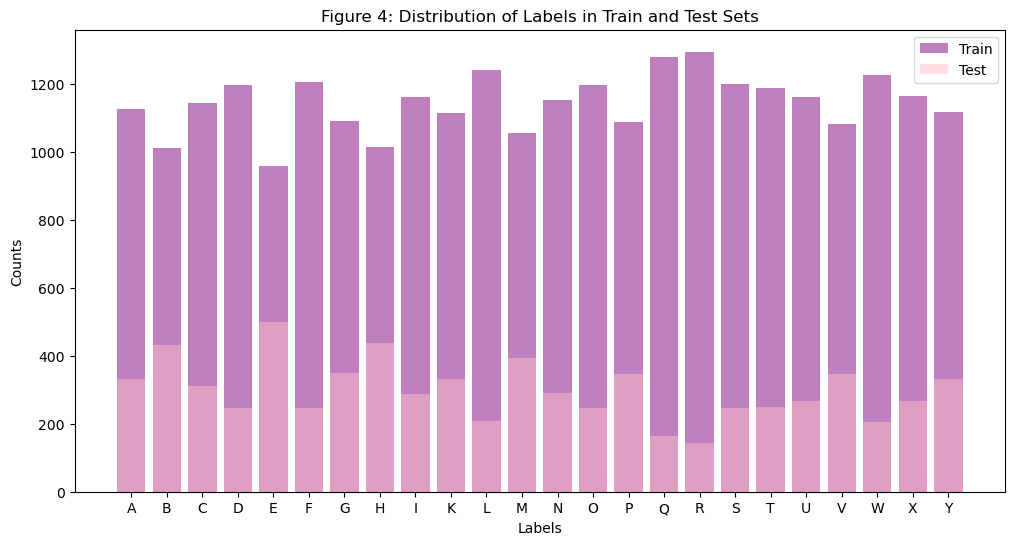

In [13]:
#function for getting label distribution
def label_distr(X_train,y_train,X_test,y_test):
    train=pd.concat([pd.DataFrame(X_train.reshape(X_train.shape[0],-1)),pd.DataFrame(y_train,columns=['label'])],axis=1)
    test=pd.concat([pd.DataFrame(X_test.reshape(X_test.shape[0],-1)),pd.DataFrame(y_test,columns=['label'])],axis=1)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Grouping the train and test sets by label and count the number of observations for each label
    train_counts = train.groupby('label').size()
    test_counts = test.groupby('label').size()

    # Custom colors
    train_color = 'purple'
    test_color = 'pink'

    # Plotting the bar chart for train & test set
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
    ax.bar(letters, train_counts, color=train_color, alpha=0.5, label='Train')
    ax.bar(letters, test_counts, color=test_color, alpha=0.5, label='Test')

    # Adding legend and labels
    ax.legend()
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_title('Figure 4: Distribution of Labels in Train and Test Sets')

    plt.show()

label_distr(X_train,y_train,X_test,y_test)

The histograms of pixel intensities are plotted below in Figure 4. It is observed that the majority of the label distributions are unimodal, left-skewed distributions. This indicates that the majority of the images have more white (or brighter) pixels than black (or darker) pixels. Additionally, most distributions have a spike of frequency at 255, which is due to the fact that most of the backgrounds in the dataset are white. 

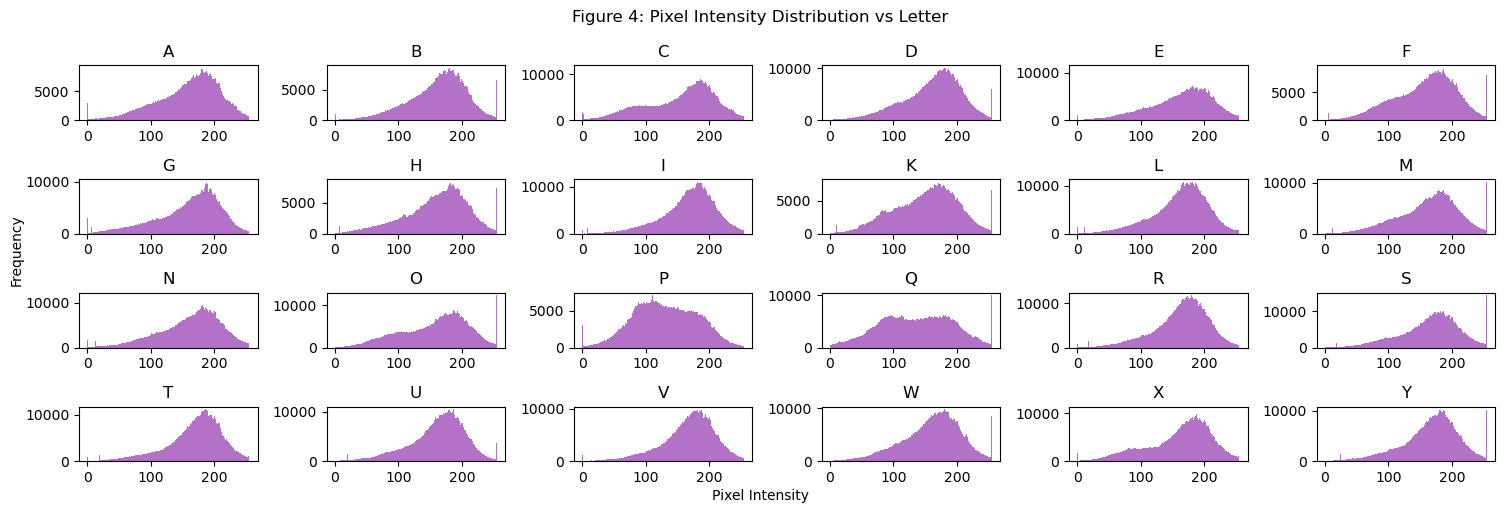

In [14]:
def label_histograms(X,y,label_dict):
    #creating dataframe for data 
    data=pd.concat([pd.DataFrame(X.reshape(X.shape[0],-1)),pd.DataFrame(y.astype(int),columns=['label'])],axis=1)
    #finding unique labels
    unique_labels = sorted(data['label'].unique())  # Sort the unique labels in ascending order
    #finding length of unique labels
    num_labels = len(unique_labels)

    fig, axes = plt.subplots(4, 6, figsize=(15,5))
    subplot_index = 0
    axes = axes.ravel()
    #plotting histograms 
    for i in unique_labels:
        if i == 9:
            continue

        label_data = data[data['label'] == i]
        pixel_values = label_data.iloc[:, 1:].values
        axes[subplot_index].hist(pixel_values.flatten(), bins=256, color='#B371C7')
        axes[subplot_index].set_title(label_dict[i])
        subplot_index += 1

    plt.suptitle('Figure 4: Pixel Intensity Distribution vs Letter')
    fig.text(0.5, 0, 'Pixel Intensity', ha='center')
    fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

label_histograms(X_train,y_train,label_dict)

## Methods <a class="anchor" id="methods"></a>

The first step taken to train the sign language classification model is reshaping the train and test images, such that they are flattened arrays of 784 pixels per image. This step is required so that the data can be used in Scikit Learn's data science functionality. The resultant shapes for the data are seen below.

In [15]:
# Reshape the data to (num_samples, 784)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (27455, 784)
y_train shape: (27455,)
X_test shape: (7172, 784)
y_test shape: (7172,)


Second, normalization is performed so that any techniques that are sensitive to the scale of the features are not affected negatively, in terms of bias towards features with high-magnitude scales or ease and speed of convergence. Normalization of the images is performed on both the train and test data by dividing by 255. 

In [16]:
#normalized data 
X_train_norm = X_train/255 
X_test_norm = X_test/255

Using the preprocessed data, initial baseline modeling was performed using Naive Bayes and Logistic Regression. The procedure for initial baseline modeling utilized Randomized Grid Search Cross Validation to identify the hyperparameters that produced the best performing models. All models in this investigation are evaluated using the classification report (depicting accuracy, precision, recall, f1-score, and support), the Matthews correlation coefficient (MCC), and the Kohen Kappa Score, which are computed using the evaluate_model function below.

In [17]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Classification report bar graph
    precision = [report[label]['precision'] for label in labels]
    recall = [report[label]['recall'] for label in labels]
    f1_score = [report[label]['f1-score'] for label in labels]

    x = np.arange(len(labels))
    width = 0.3

    # Define custom sequential colormap
    sequence = ['#F7E8F6', '#F1C6E7','#E5B0EA','#BD83CE','#B371C7']
    divergence = ['#f8df81','#f6aa90','#f6b4bf','#B371C7','#badfda']
    cmap = ListedColormap(sequence)

    fig, ax = plt.subplots(figsize=(12,8))
    rects1 = ax.bar(x - width, precision, width, label='Precision', color=divergence[4])
    rects2 = ax.bar(x, recall, width, label='Recall', color=divergence[2])
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color=divergence[3])


    ax.set_xlabel('Letters')
    ax.set_ylabel('Score')
    ax.set_title('Classification Report')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap=cmap, ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()


#### Initial Model Results

For initial baseline modeling, Naive Bayes and Logistic Regression were used and trained on the ~27k train images. The Randomized Grid Search CV is used to find the best hyperparameters for Logistic Regression. The results for Naive Bayes are seen in [Appendix A](#a-naive-bayes-initial-results) and [Appendix B](#b-logistic-regression-initial-results). 

The Logistic Regression model has achieved a high training accuracy (1.00) and a relatively higher test accuracy (0.67). While the test accuracy is better than the Naive Bayes model, there is still a large performance gap between the train and test accuracies, indicating high level of overfitting. 

In summary, the Naive Bayes and Logistic Regression models both exhibit strong indications of overfitting due to the large gap in train and test accuracies.

#### Adressing overfitting
To address the overfitting issues exhibited by the initial model results, three methods were used: data augmentation, dimension reduction, and regularization.

Data augmentation: Data augmentation addressses overfitting by increasing the amount of images available for training by using parameters like rotation, scaling, and translation to transform the original images to augmented ones. This will not only increase the number of training images, but also increase the variability (noise) in the images, allowing the model to be more generalized. 

Dimension reduction: LDA, SVD, TSN-E, PCA, and feature selection approaches (HOG) were used extract useful information from the dataset while reducing the dimensionality of the data before training. This helps remove irrelevant or redundant features and focus on the most informative ones, reducing the risk of overfitting. Moreover, this results in a less complex model, which reduces the liklihood for overfitting.  

Regularization: L1 or L2 regularization techniques were used to add penalty terms to the model weights during the training process, which discourages complex and overfitted models. Tuning regularization parameters helps by finding the balance between fitting the training data well and generalizing it to new data. 


### Data Augmentation Methodology

First, data preprocessing, like reshaping the image arrays, so that it is compatible with the Keras Data Generator function is performed. The extra dimension is added to the image array to represent the batch size for the Keras Data Generator. The Keras Data Generator expects an input array of rank 4, where the first dimension represents the batch size. Since one image is being passed at a time to the data generator, it is required to add an extra dimension to the image array to make its shape (1, height, width, channels).

In [18]:
#define image resolution 
res = (28,28)

# Reshape the data to images adding color dimention
X_train = X_train.reshape(X_train.shape[0], res[0], res[1], 1)
X_test = X_test.reshape(X_test.shape[0], res[0], res[1], 1)

An ImageDataGenerator object is created with specific parameters for data augmentation. The parameters include rotation_range, zoom_range, width_shift_range, height_shift_range, shear_range, brightness_range, and fill_mode. These parameters define the range and type of transformations that will be applied to the images during data augmentation, such as rotation, zooming, shifting, shearing, adjusting brightness, and filling missing pixels.

In [19]:
# Creating an ImageDataGenerator object with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest')


Data augmentation is applied to the test and train sets separately by looping over each image in the original sets.
For each image, three random transformations are generated using the ImageDataGenerator object defined earlier, and the transformed images are added to the augmented sets along with their corresponding labels.
Finally, the augmented data is converted to numpy arrays, resulting in X_train_aug, y_train_aug, X_test_aug, and y_test_aug, which contain the augmented images and labels for both the training and test sets.

In [20]:
# Apply data augmentation to the training set
X_train_augmented = []
y_train_augmented = []
for i in range(X_train.shape[0]):
    img = X_train[i]
    label = y_train[i]
    for j in range(3):
        x_augmented = datagen.random_transform(img)
        X_train_augmented.append(x_augmented)
        y_train_augmented.append(label)

# Apply data augmentation to the test set
X_test_augmented = []
y_test_augmented = []
for i in range(X_test.shape[0]):
    img = X_test[i]
    label = y_test[i]
    for j in range(3):
        x_augmented = datagen.random_transform(img)
        X_test_augmented.append(x_augmented)
        y_test_augmented.append(label)

# Convert the augmented data to numpy arrays
X_train_aug = np.array(X_train_augmented)
y_train_aug = np.array(y_train_augmented)
X_test_aug = np.array(X_test_augmented)
y_test_aug = np.array(y_test_augmented)

The arrays containing the augmented data and the original data are reshaped to have dimensions (number of samples, 28, 28) to match the image dimensions.

In [23]:

#rehape arrays 
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0],28,28)
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0],28,28)
X_train = X_train.reshape(X_train.shape[0],28,28)
X_test = X_test.reshape(X_test.shape[0],28,28)

The augmented data is combined with the original data by concatenating the arrays along the first axis (row-wise), resulting in the combined training and test sets with increased sample size. As seen by the shapes, using data augmentation, the train dataset size increases from ~27k to ~101k images and the test size increases from ~7k to 29k. This drastically increases the amount of new data that can be trained on, thus reducing the liklihood of overfitting. 

In [25]:
# Concatenate the arrays along the first axis (i.e., row-wise)
X_train_com = np.concatenate((X_train_aug, X_train), axis=0)
y_train_com = np.concatenate((y_train_aug, y_train), axis=0)

X_test_com = np.concatenate((X_test_aug, X_test), axis=0)
y_test_com = np.concatenate((y_test_aug, y_test), axis=0)

# Print the shape of the combined array
print("Shape of combined array:", X_train_com.shape)
print("Shape of combined array:", X_test_com.shape)

Shape of combined array: (109820, 28, 28)
Shape of combined array: (28688, 28, 28)


# MOVE BASELINE INTO APPENDIX, REFERENCE OVERFIT RESULTS, ADD DETAILS ON HOW WE ADDRESSED OVERFITTING (DATA AUG,DIMENSIONALITY REDUCTION,REGULARIZATION)
# THEN ADD INFO ABOUT THE MAIN ML MODELS INTO THE APPENDIX, REFERENCE THE RESULTS IN A SIMPLIFIED GRAPH SHOWING THE COMPARISION IN PERFROMANCE, ONLY SHOW FINE DETAIL ON BEST PERFORMING MODELS
# BELOW CELLS ARE ONES THAT HAVE NOT BEEN FORMATED OR REVIEWED BY AL 

#### EDA for Augmented Data

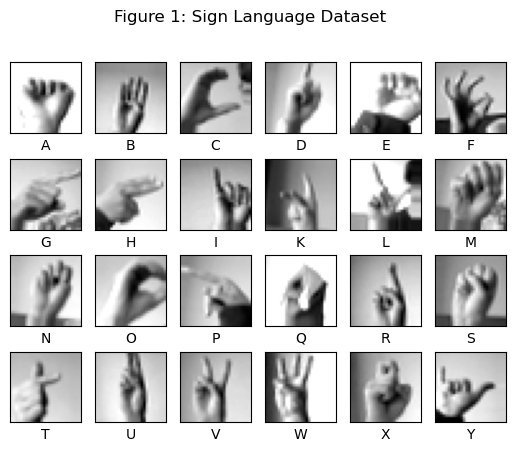

In [26]:
#visualizing examples from the data set
fig = visualize_data(X_train_com,y_train_com,label_dict)
fig

Fig. 1 diplays example images representing each letter in the augmented dataset. These images are grayscale, with dimensions of 28x28 pixels. The augmentation process introduces variations such as changes in brightness, darkness, and rotations, resulting in a diverse set of images for each letter.

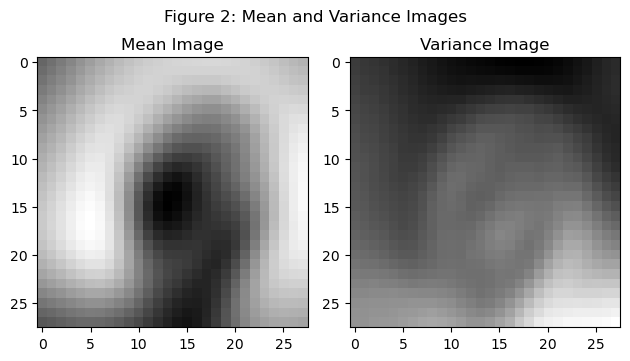

In [27]:
#Plotting mean and varience image
mean_var_image(X_train_com)


Figure 2 displays the Mean Image of the augmented dataset, indicating that the hands are centered within the images with a small border around them. The background generally appears white, although slight variations can be observed in the far corners of the images. The Variance Image reveals that the background of the augmented images is not consistently uniform, exhibiting some degree of variation.

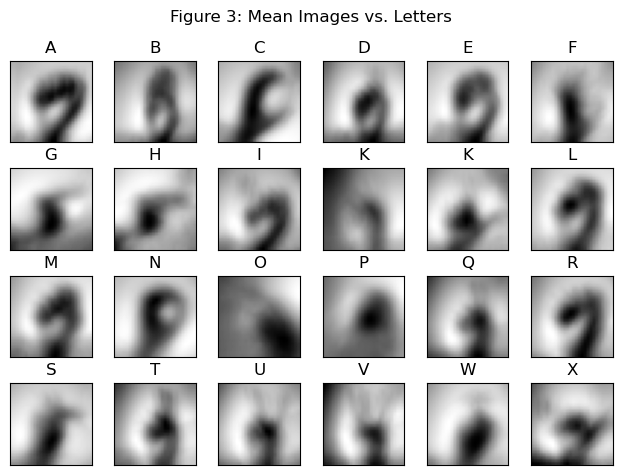

In [28]:
# Create the label dictionary
label_dict = get_label_dict(y_train_com)

# Call the function to plot the mean images
plot_mean_images(X_train_com, y_train_com, label_dict)


Figure 3 depicts the Mean Image for each letter in the augmented dataset, representing the average hand positions for each class. Letters with extended fingers exhibit blurriness around the fingers, indicating higher variability in finger positions. 

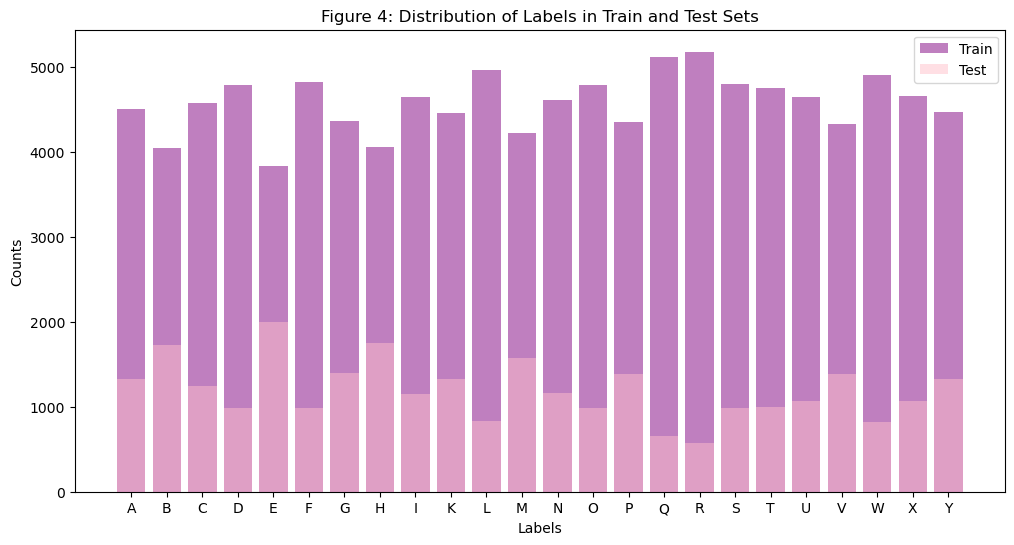

In [29]:
# Label distribuiton for augmented data
label_distr(X_train_com,y_train_com,X_test_com,y_test_com)

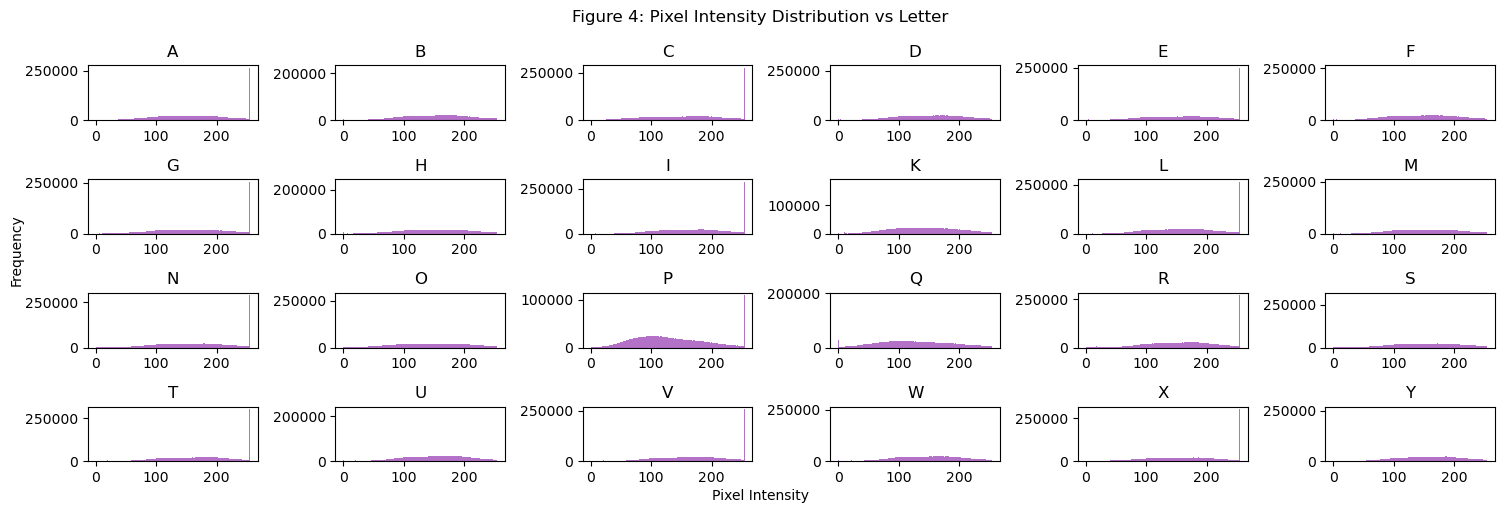

In [30]:
# Histrogram for each pixel
label_histograms(X_train_com,y_train_com,label_dict)

## Evaluation <a class="anchor" id="evaluation"></a>

#### Main ML Model
After Adressing overfittting issue two mechine learning models were employed as baselines, namely Naive Bayes and Logistic Regression, to establish a performance benchmark. Additionally, more advanced models such as Random Forest, Support Vector Machines (SVM), and XGBoost were utilized, along with a stacking ensemble technique. This comprehensive approach aimed to leverage the strengths of each model, resulting in improved predictive accuracy and robustness for the given task.

In [50]:

X_train = X_train_com
y_train = y_train_com

X_test = X_test_com
y_test = y_test_com

# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (109820, 28, 28)
y_train shape: (109820,)
X_test shape: (28688, 28, 28)
y_test shape: (28688,)


In [51]:
# Normalizing the data
X_train_norm = X_train/255
X_test_norm = X_test/255

### HOG
The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image.

The code below defines the parameters for Histogram of Oriented Gradients (HOG) feature extraction, including the number of orientations, pixels per cell, and cells per block. The extract_features function is then defined to extract HOG features from a single image using these parameters. Finally, the function is applied to all images in the training and test sets, resulting in X_train_features and X_test_features arrays that contain the extracted HOG features for each image.

In summary, this code performs HOG feature extraction on the normalized images in the training and test sets using predefined parameters, producing arrays of HOG features for further analysis and modeling.

In [52]:
# Define the HOG parameters
orientations = 9
pixels_per_cell = (2, 2)
cells_per_block = (1, 1)

# Function to extract HOG features from a single image
def extract_features(img):
    #print(f"Image shape before HOG: {img.shape}")
    features = hog(img, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True,
                   block_norm='L2-Hys')
    #print(f"Feature shape: {features.shape}")
    return features

In [53]:
# Apply the extract_features function to all images in X_train and X_test
X_train_features = np.array([extract_features(img) for img in X_train_norm])
X_test_features = np.array([extract_features(img) for img in X_test_norm])

print(f"X_train_features Shape: {X_train_features.shape}")
print(f"X_test_features Shape: {X_test_features.shape}")


X_train_features Shape: (109820, 1764)
X_test_features Shape: (28688, 1764)


The code below performs Principal Component Analysis (PCA) on the extracted HOG features from the training and test sets. It reduces the dimensionality of the feature vectors to 30 components and transforms the data accordingly. The shape of hog_test_pca and hog_train_pca is then printed to show the new dimensions of the transformed feature vectors.

In [54]:

pca = PCA(n_components=30)
hog_train_pca = pca.fit_transform(X_train_features)
hog_test_pca=pca.transform(X_test_features)
print(hog_test_pca.shape)
print(hog_train_pca.shape)

(28688, 30)
(109820, 30)


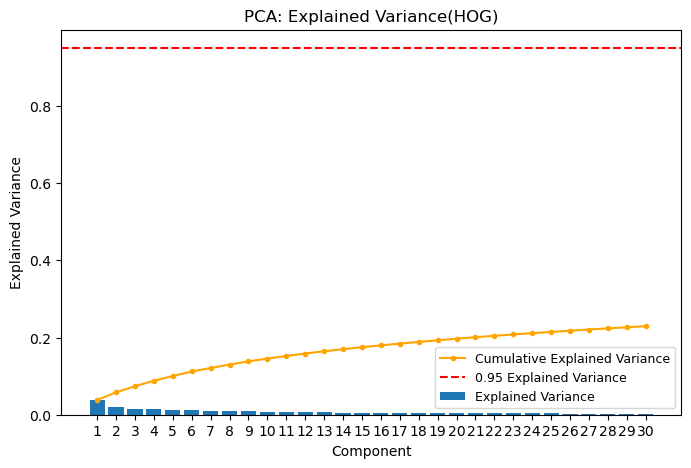

In [55]:

#getting explained variance ratio from the lda model 
evr = pca.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('PCA: Explained Variance(HOG)');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);


The figure above shows the explained variance ratio and cumulative explained variance for each principal component in the PCA analysis. It helps visualize the amount of variance explained by each component and the cumulative variance explained as more components are considered. The red dashed line represents the threshold of 0.95 explained variance, indicating the number of components needed to capture at least 95% of the total variance.

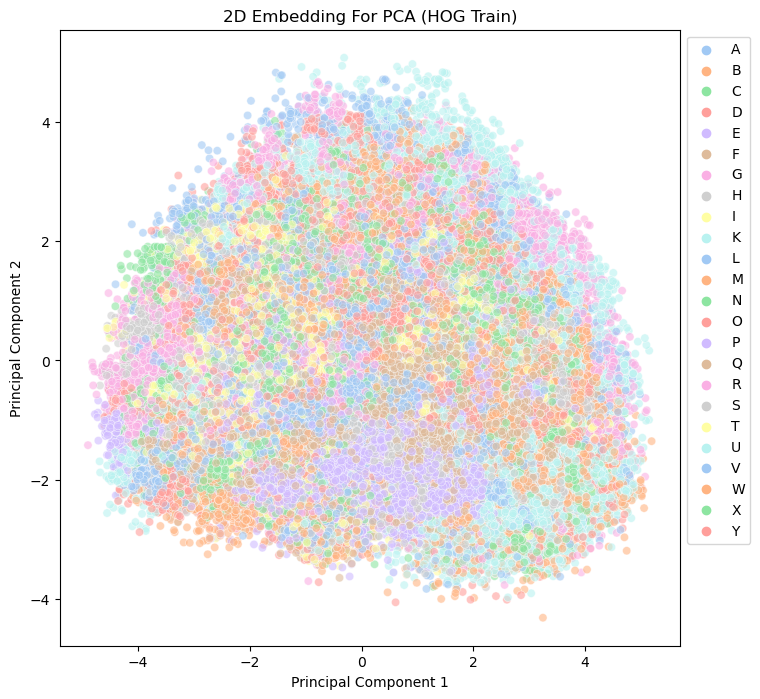

In [56]:
# Plotting scatter plot for hog_train_pca
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.scatterplot(x=hog_train_pca[:, 0], y=hog_train_pca[:, 1], hue=y_train, palette='pastel', alpha=0.6)
handler, _ = ax.get_legend_handles_labels()
plt.legend(handler, letters, bbox_to_anchor=(1, 1))
plt.title('2D Embedding For PCA (HOG Train)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The scatter plot shows a 2D embedding of the HOG features after performing PCA (Principal Component Analysis) on the training data. Each point represents an image, and its position on the plot is determined by the values of the first and second principal components. The colors of the points correspond to the different letter classes, and the legend provides a visual representation of the class labels.

In [70]:
train_acc = []
test_acc = []

for num_components in range(6,60,3):
  print(num_components)
  pca = PCA(n_components=num_components)
  hog_train_pca = pca.fit_transform(X_train_features)
  hog_test_pca = pca.transform(X_test_features)
  lr = LogisticRegression(C=3.4647045830997407,
                        max_iter=3171, 
                        penalty="l2", 
                        solver="liblinear",
                        warm_start=False)
  lr.fit(hog_train_pca,y_train)
  y_pred_lr_train = lr.predict(hog_train_pca)
  y_pred_lr_test = lr.predict(hog_test_pca)
  train_acc.append(accuracy_score(y_train,y_pred_lr_train))
  test_acc.append(accuracy_score(y_test,y_pred_lr_test))

6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57


In [72]:
print(train_acc)
print(test_acc)

[0.28931888544891643, 0.3498452012383901, 0.40735749408122385, 0.46030777636131853, 0.5036059005645602, 0.5399653979238754, 0.568384629393553, 0.5877526862138044, 0.6096976871243853, 0.6241850300491714, 0.6361500637406665, 0.6451739209615734, 0.6531870333272628, 0.6622837370242215, 0.6715170278637771, 0.6766618102349299, 0.6844654889819705, 0.6919322527772719]
[0.2694854991634133, 0.323271054099275, 0.3621026213050753, 0.40107361963190186, 0.44544757389849415, 0.4710680423870608, 0.4909021193530396, 0.5098996095928612, 0.5221346904629113, 0.5391104294478528, 0.5502997769102064, 0.5559118795315114, 0.564835471277189, 0.5741773563859454, 0.5845998326826548, 0.5888873396542108, 0.5944645844952593, 0.6024818739542666]


ValueError: x and y must have same first dimension, but have shapes (26,) and (18,)

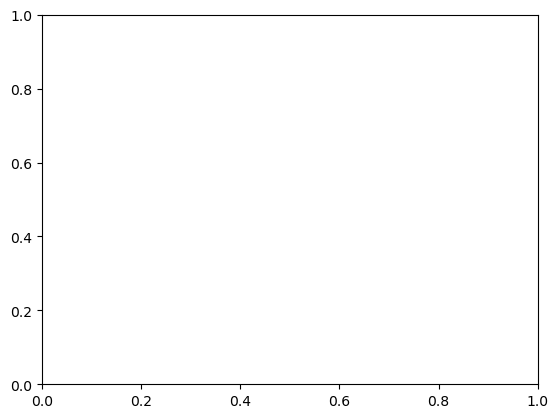

In [73]:
plt.plot(range(6,84,3),train_acc,label='Train')
plt.plot(range(6,84,3),test_acc,label='Test')
plt.title('Logistic Regression Accuracy vs. Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()

### LDA

Dimensionality reduction is an important step in the Data Science pipeline because it reduces the complexity of the model by reducing the number of input features. This results in a decreased likelihood for the model to overfit on the training data. Additionally, removing noise and unimportant/redundant features can lead to better performing models. Lastly, reducing dimensionality will decrease the computational and memory requirements to train and use the model.

Linear Discriminant Analysis is a linear supervised learning algorithm used for classification tasks by projecting the data to a lower dimensionality that maximizes the separation between classes. This is achieved by finding the vectors in the feature space that best separates the different classes of the data and minimizes the variance of the data within each class.

In [62]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [63]:
# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (109820, 784)
y_train shape: (109820,)
X_test shape: (28688, 784)
y_test shape: (28688,)


In [64]:
# Normalizing the data
X_train_norm = X_train/255
X_test_norm = X_test/255

In [65]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train_norm,y_train)

LinearDiscriminantAnalysis()

The explained variance ratio of the LDA components (linear discriminants) indicate how much information is retained at each component. As a result, the cumulative explained variance can help determine how many components to keep for dimensionality reduction.

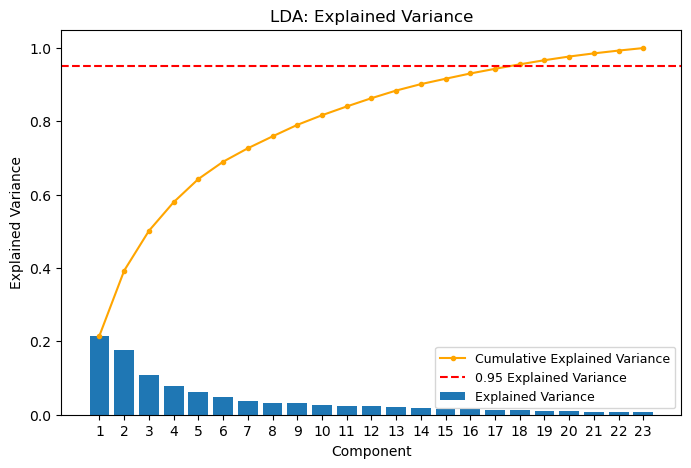

In [66]:
#getting explained variance ratio from the lda model 
evr = lda.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

Looking at the plot above, it can be interpreted that there is an elbow at around component 3 - 5, however, this would only account for about .4 - .55 of the cumulative variance explained. As a result, for the purposes of modeling, all components resulted from the LDA computation will be used.

This results in a dimensionality reduction of 784 to 23.

In [67]:
#fit on training data and transform
X_train_lda = lda.transform(X_train_norm)
X_test_lda = lda.transform(X_test_norm)


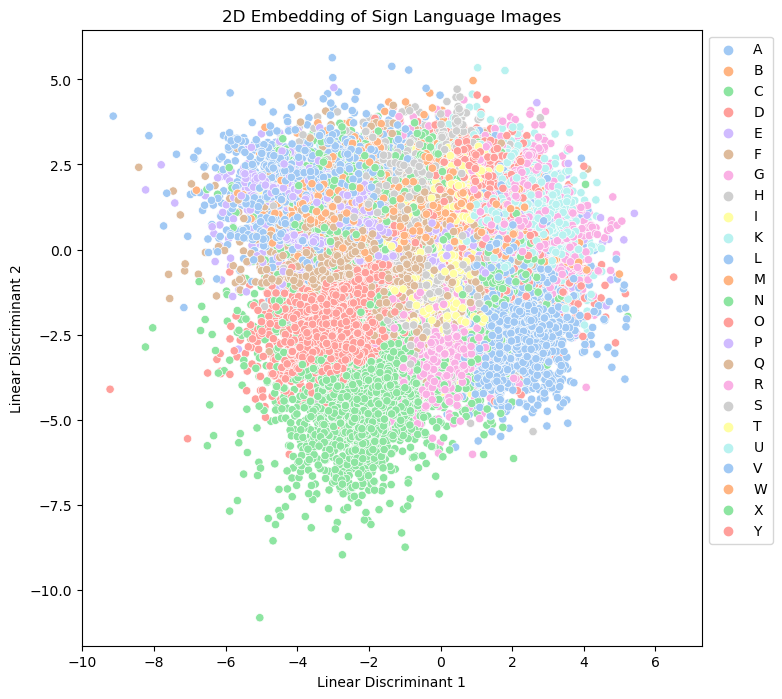

In [68]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_lda[:,0], y = X_train_lda[:,1], hue = y_train, palette = 'pastel');
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Linear Discriminant 1');
plt.ylabel('Linear Discriminant 2');

Plotting components 1 and 2 from the LDA computation, it is observed that it does reasonably well at separating certain letters from others. For example, X and Y is separated well from the other letters using the first two linear discriminants. The other letters likely require more components to result in a clearer separation between the classes.

### Combining features

In [69]:
# concatenate PCA and LDA features
X_train_combined = np.concatenate((hog_train_pca, X_train_lda), axis=1)
X_test_combined = np.concatenate((hog_test_pca, X_test_lda), axis=1)

print(f"X_train Shape: {X_train_combined.shape}")
print(f"X_test Shape: {X_test_combined.shape}")

X_train Shape: (109820, 53)
X_test Shape: (28688, 53)


In [74]:
X_train = X_train_combined
X_test = X_test_combined
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


### Naive bayes

In [76]:
# Defining Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# applying NB on normalized train data
y_pred_train = gnb.predict(X_train)

# applying NB on normalized test data
y_pred_test = gnb.predict(X_test)

Accuracy: 0.6905299581132762
Classification report:
              precision    recall  f1-score   support

           A       0.73      0.69      0.71      4504
           B       0.80      0.71      0.75      4040
           C       0.90      0.76      0.83      4576
           D       0.67      0.58      0.62      4784
           E       0.72      0.64      0.68      3828
           F       0.82      0.74      0.77      4816
           G       0.81      0.74      0.77      4360
           H       0.73      0.70      0.71      4052
           I       0.64      0.74      0.69      4648
           K       0.67      0.60      0.63      4456
           L       0.77      0.75      0.76      4964
           M       0.64      0.58      0.61      4220
           N       0.62      0.53      0.57      4604
           O       0.81      0.80      0.81      4784
           P       0.88      0.86      0.87      4352
           Q       0.84      0.87      0.85      5116
           R       0.44      

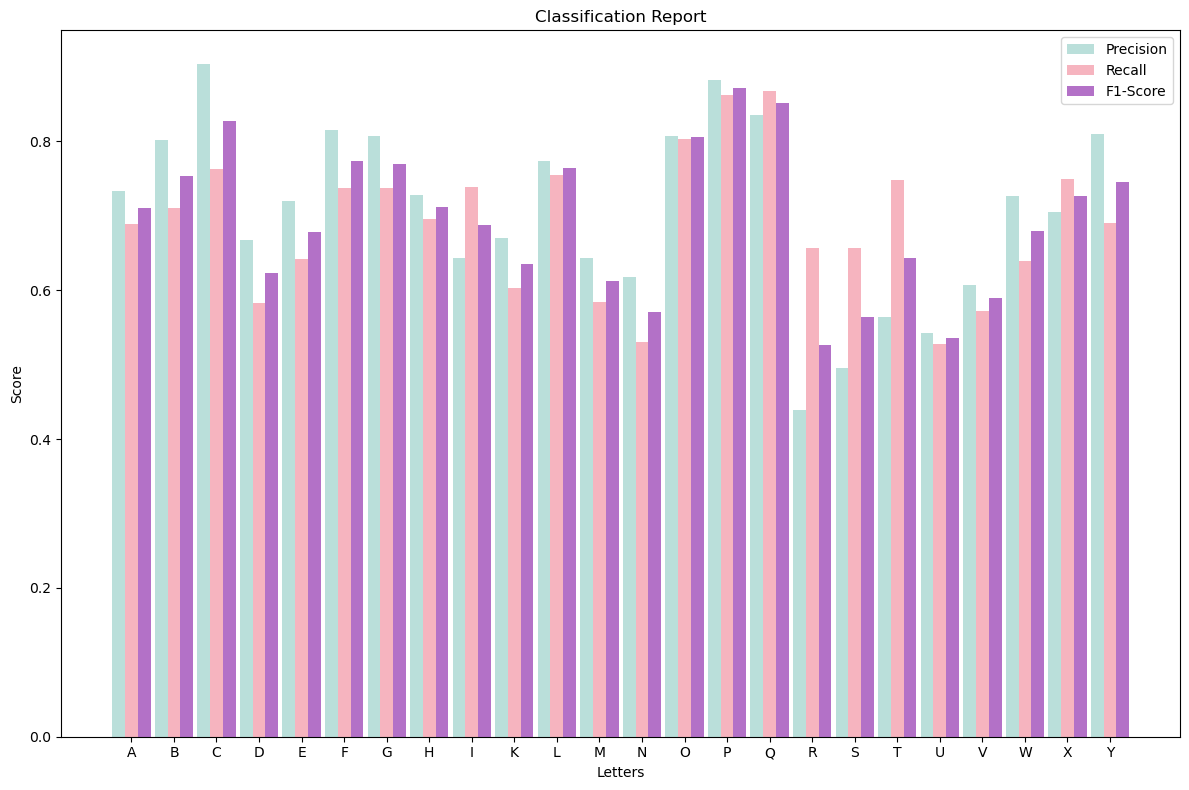

MCC: 0.6773744850858269
Cohen's Kappa: 0.6769212656002532


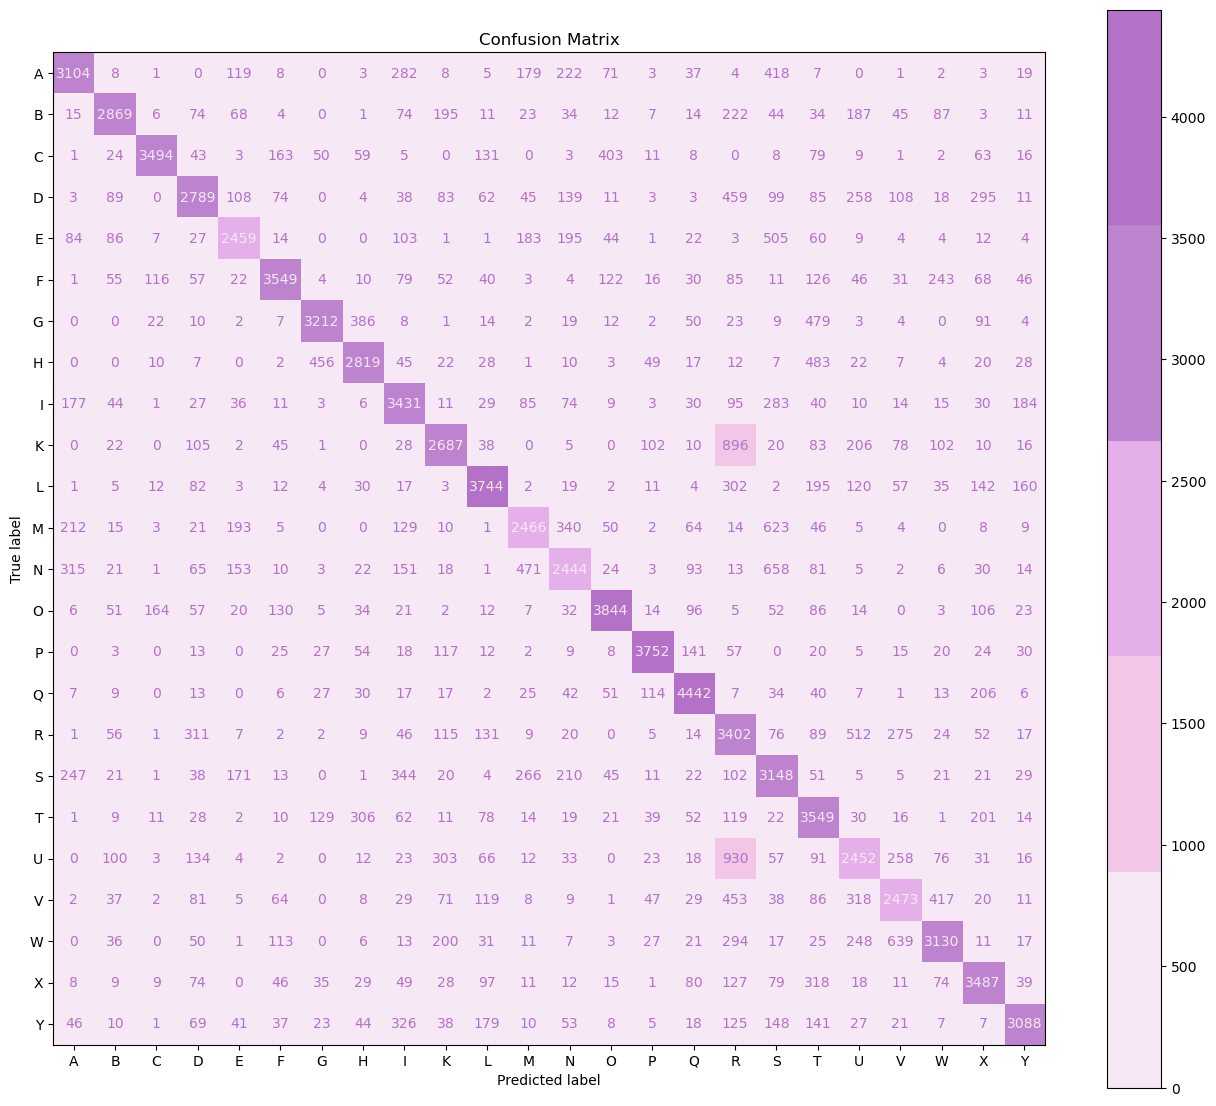

Accuracy: 0.5632668711656442
Classification report:
              precision    recall  f1-score   support

           A       0.68      0.69      0.68      1324
           B       0.76      0.48      0.59      1728
           C       0.91      0.59      0.72      1240
           D       0.44      0.55      0.49       980
           E       0.70      0.56      0.62      1992
           F       0.64      0.60      0.62       988
           G       0.69      0.64      0.66      1392
           H       0.81      0.65      0.72      1744
           I       0.53      0.55      0.54      1152
           K       0.48      0.46      0.47      1324
           L       0.68      0.81      0.74       836
           M       0.56      0.46      0.50      1576
           N       0.42      0.41      0.42      1164
           O       0.65      0.65      0.65       984
           P       0.90      0.84      0.87      1388
           Q       0.63      0.81      0.71       656
           R       0.15      

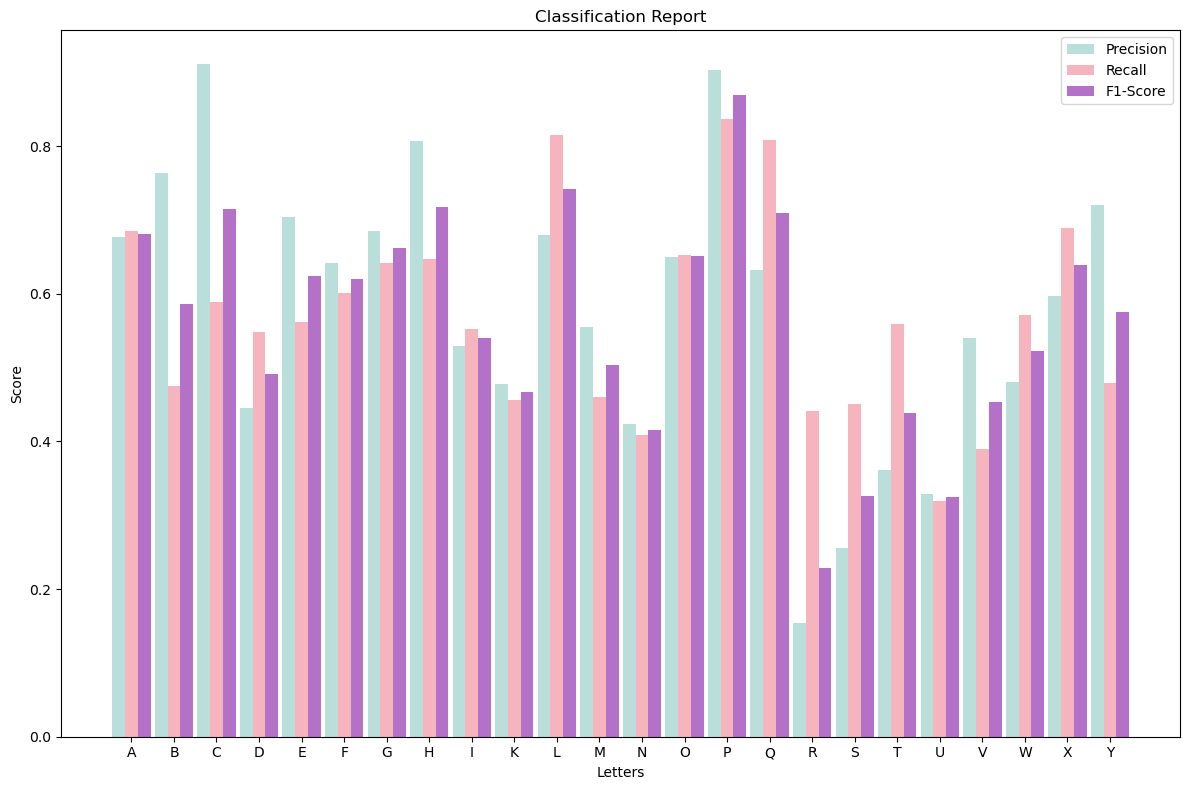

MCC: 0.545281864226818
Cohen's Kappa: 0.544065722941411


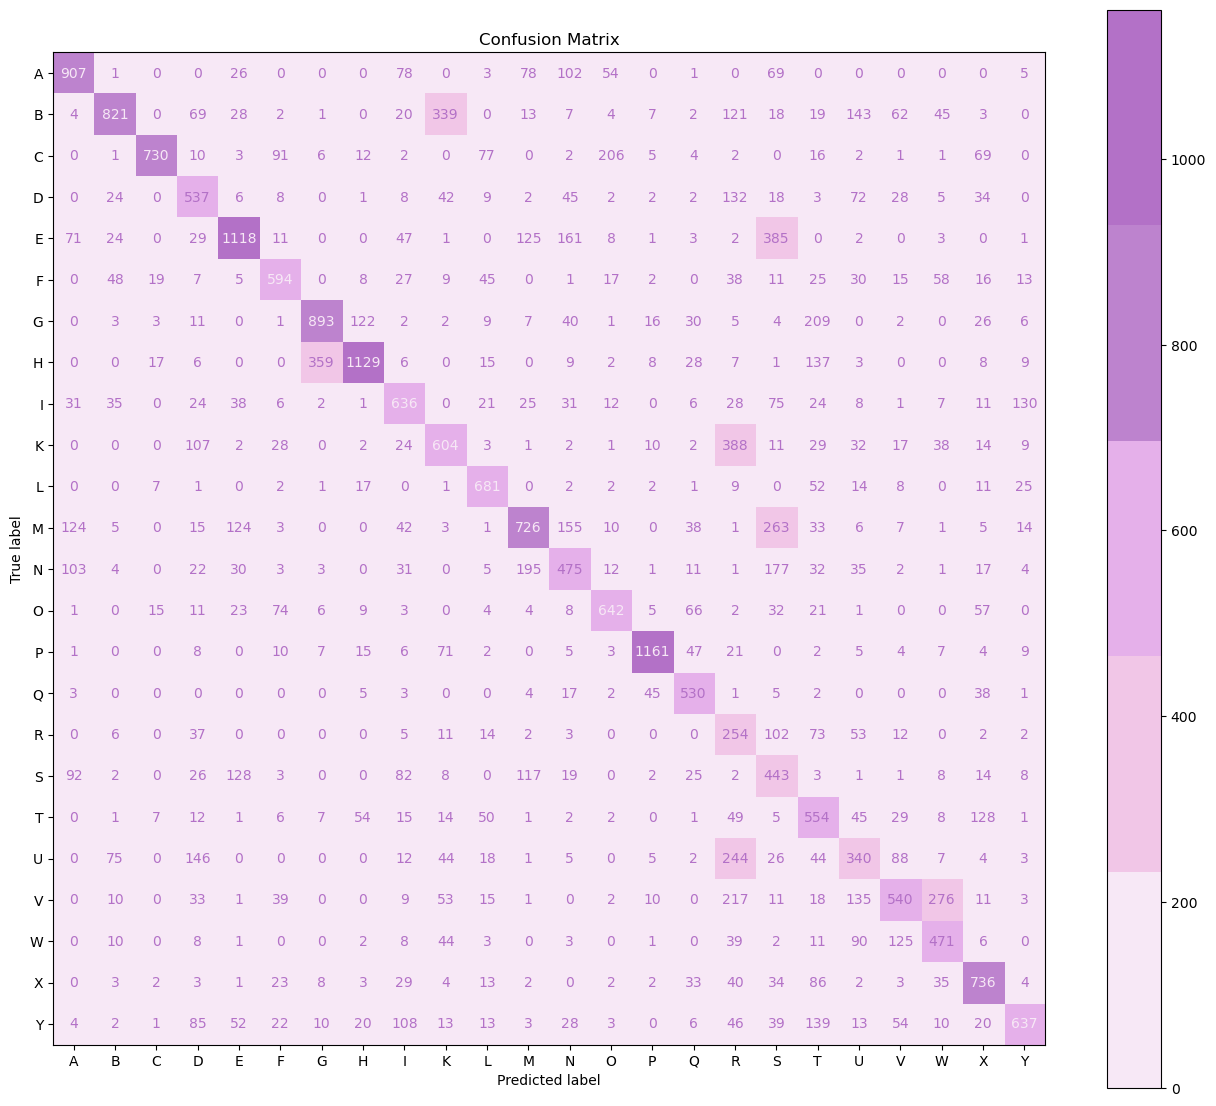

In [77]:
# Evaluating on train set
evaluate_model(y_train, y_pred_train, letters)

# Evaluating on test set
evaluate_model(y_test, y_pred_test, letters)

### Logistic Regression

In [78]:
lr = LogisticRegression(C=0.22564631610840102,
                        max_iter=2391, 
                        penalty="l2", 
                        solver='newton-cg',
                        warm_start=False)

lr.fit(X_train, y_train)

# applying Logistic regression and predicting on train
y_pred_lr_train = lr.predict(X_train)
# testing logistic regression on test data
y_pred_lr_test = lr.predict(X_test)


Accuracy: 0.7694044800582772
Classification report:
              precision    recall  f1-score   support

           A       0.77      0.81      0.79      4504
           B       0.82      0.82      0.82      4040
           C       0.88      0.87      0.87      4576
           D       0.71      0.71      0.71      4784
           E       0.78      0.72      0.75      3828
           F       0.79      0.79      0.79      4816
           G       0.82      0.81      0.81      4360
           H       0.80      0.81      0.80      4052
           I       0.74      0.74      0.74      4648
           K       0.75      0.76      0.75      4456
           L       0.84      0.86      0.85      4964
           M       0.69      0.63      0.66      4220
           N       0.68      0.66      0.67      4604
           O       0.84      0.83      0.83      4784
           P       0.88      0.89      0.89      4352
           Q       0.89      0.90      0.90      5116
           R       0.65      

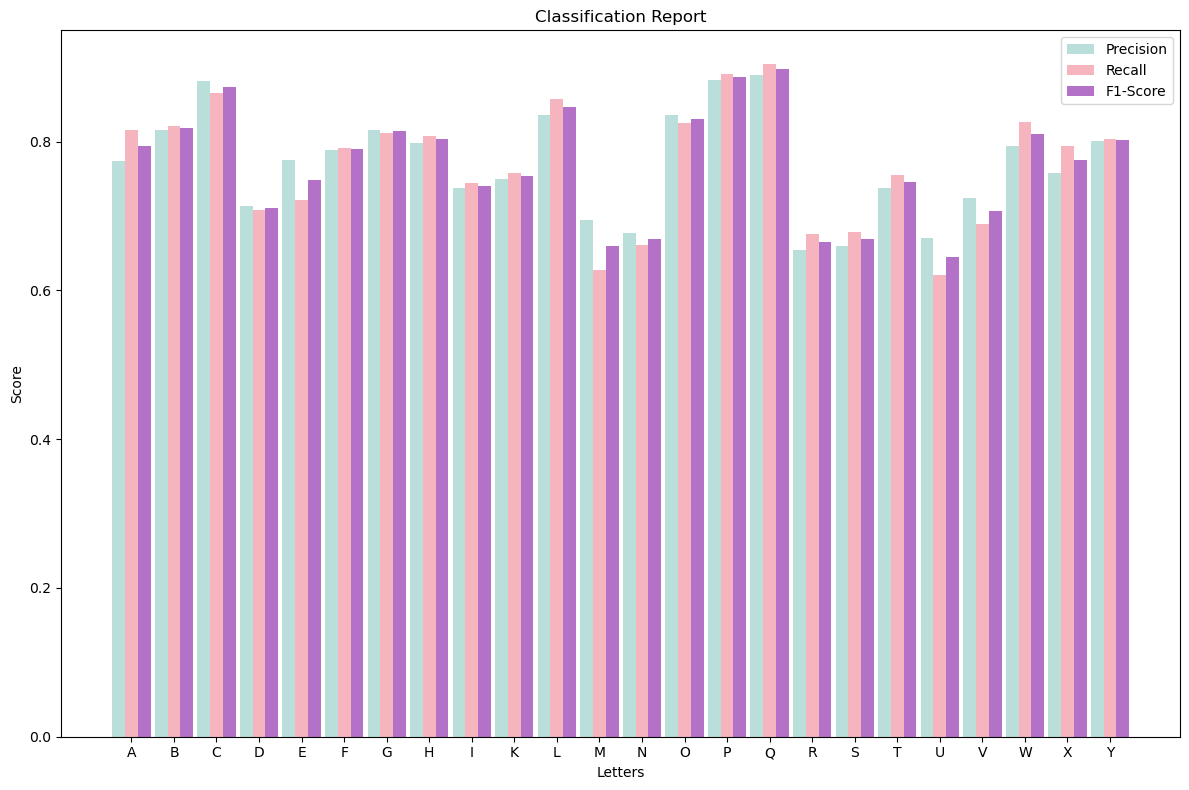

MCC: 0.7593337133846444
Cohen's Kappa: 0.7593119420125211


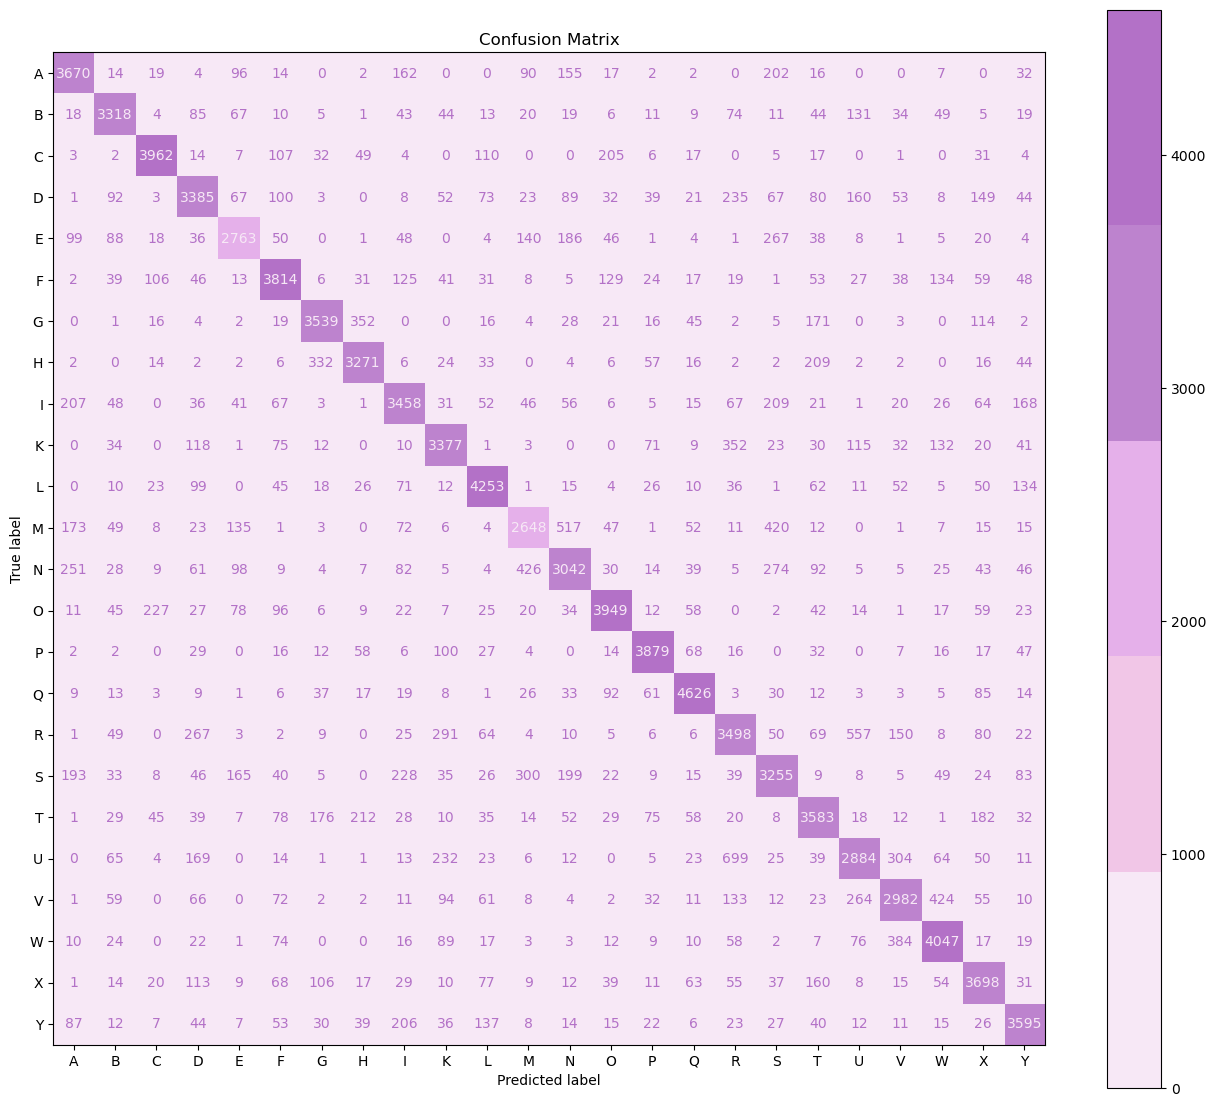

Accuracy: 0.6532696597880647
Classification report:
              precision    recall  f1-score   support

           A       0.72      0.81      0.76      1324
           B       0.80      0.65      0.71      1728
           C       0.91      0.78      0.84      1240
           D       0.63      0.65      0.64       980
           E       0.76      0.64      0.69      1992
           F       0.63      0.66      0.65       988
           G       0.71      0.71      0.71      1392
           H       0.87      0.71      0.78      1744
           I       0.62      0.58      0.60      1152
           K       0.58      0.58      0.58      1324
           L       0.73      0.90      0.81       836
           M       0.58      0.49      0.53      1576
           N       0.44      0.45      0.44      1164
           O       0.71      0.68      0.70       984
           P       0.89      0.87      0.88      1388
           Q       0.72      0.87      0.79       656
           R       0.27      

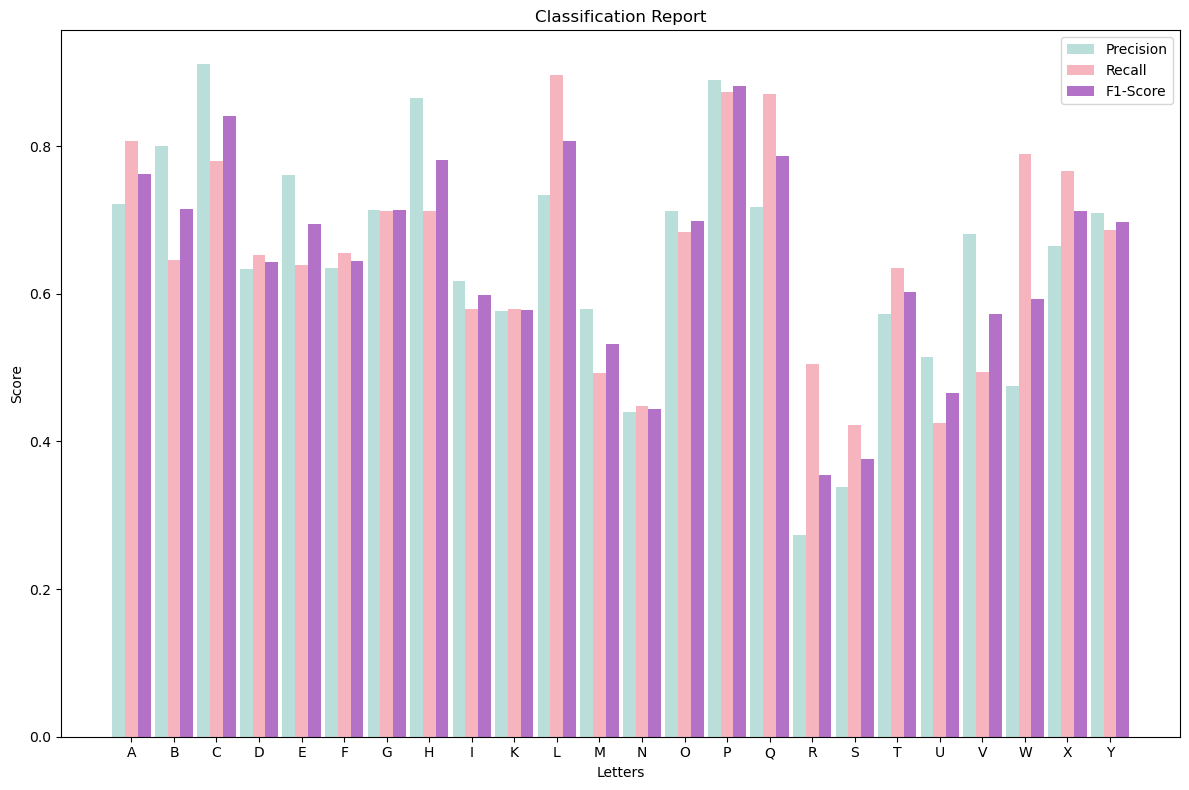

MCC: 0.6381457820243219
Cohen's Kappa: 0.637620633120249


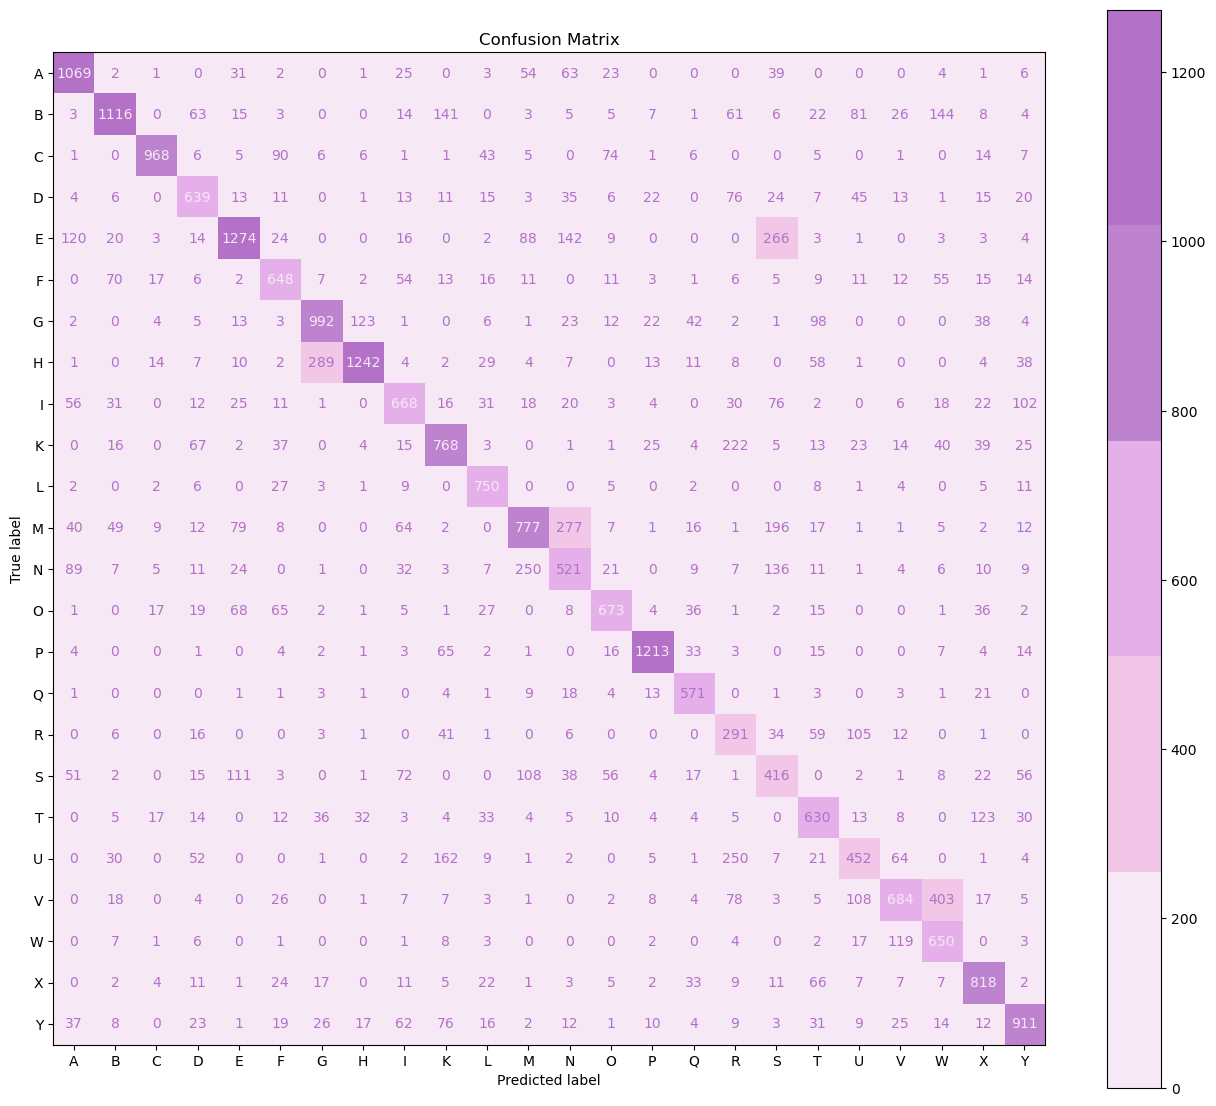

In [82]:
evaluate_model(y_train, y_pred_lr_train, letters)
evaluate_model(y_test, y_pred_lr_test, letters)


Accuracy: 0.6532696597880647
Classification report:
              precision    recall  f1-score   support

           A       0.72      0.81      0.76      1324
           B       0.80      0.65      0.71      1728
           C       0.91      0.78      0.84      1240
           D       0.63      0.65      0.64       980
           E       0.76      0.64      0.69      1992
           F       0.63      0.66      0.65       988
           G       0.71      0.71      0.71      1392
           H       0.87      0.71      0.78      1744
           I       0.62      0.58      0.60      1152
           K       0.58      0.58      0.58      1324
           L       0.73      0.90      0.81       836
           M       0.58      0.49      0.53      1576
           N       0.44      0.45      0.44      1164
           O       0.71      0.68      0.70       984
           P       0.89      0.87      0.88      1388
           Q       0.72      0.87      0.79       656
           R       0.27      

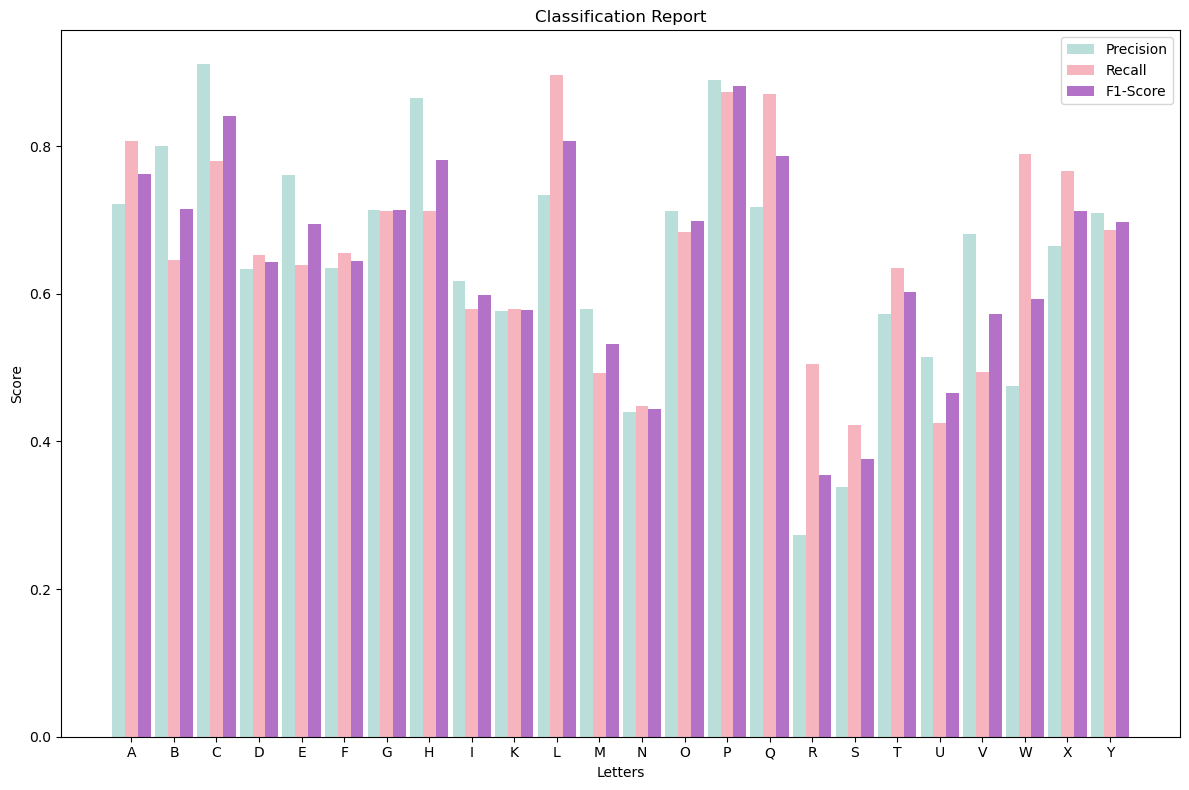

MCC: 0.6381457820243219
Cohen's Kappa: 0.637620633120249


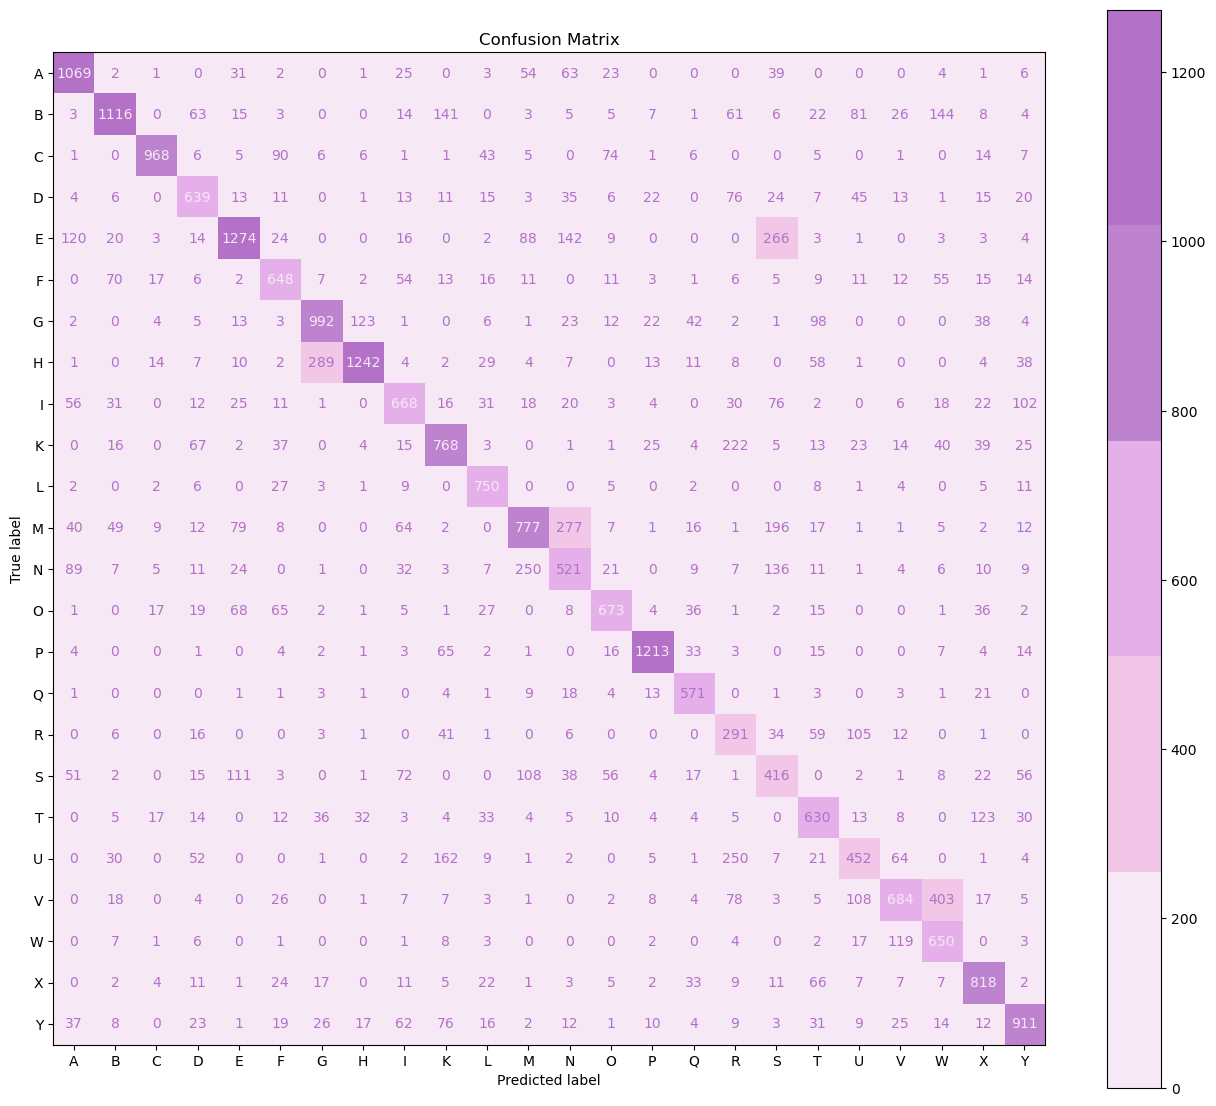

### Random Forest

In [81]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                                   max_features=5, max_depth=5, random_state=42)

rfc.fit(X_train, y_train)

# applying Logistic regression and predicting on train
y_pred_train = rfc.predict(X_train)
# testing logistic regression on test data
y_pred_test = rfc.predict(X_test)

Accuracy: 0.5358131487889274
Classification report:
              precision    recall  f1-score   support

           A       0.45      0.80      0.58      4504
           B       0.77      0.46      0.58      4040
           C       0.72      0.78      0.75      4576
           D       0.57      0.46      0.51      4784
           E       0.63      0.43      0.51      3828
           F       0.65      0.59      0.62      4816
           G       0.64      0.66      0.65      4360
           H       0.70      0.54      0.61      4052
           I       0.49      0.56      0.52      4648
           K       0.51      0.43      0.46      4456
           L       0.49      0.72      0.59      4964
           M       0.50      0.42      0.46      4220
           N       0.54      0.34      0.41      4604
           O       0.65      0.70      0.67      4784
           P       0.65      0.78      0.71      4352
           Q       0.63      0.83      0.71      5116
           R       0.26      

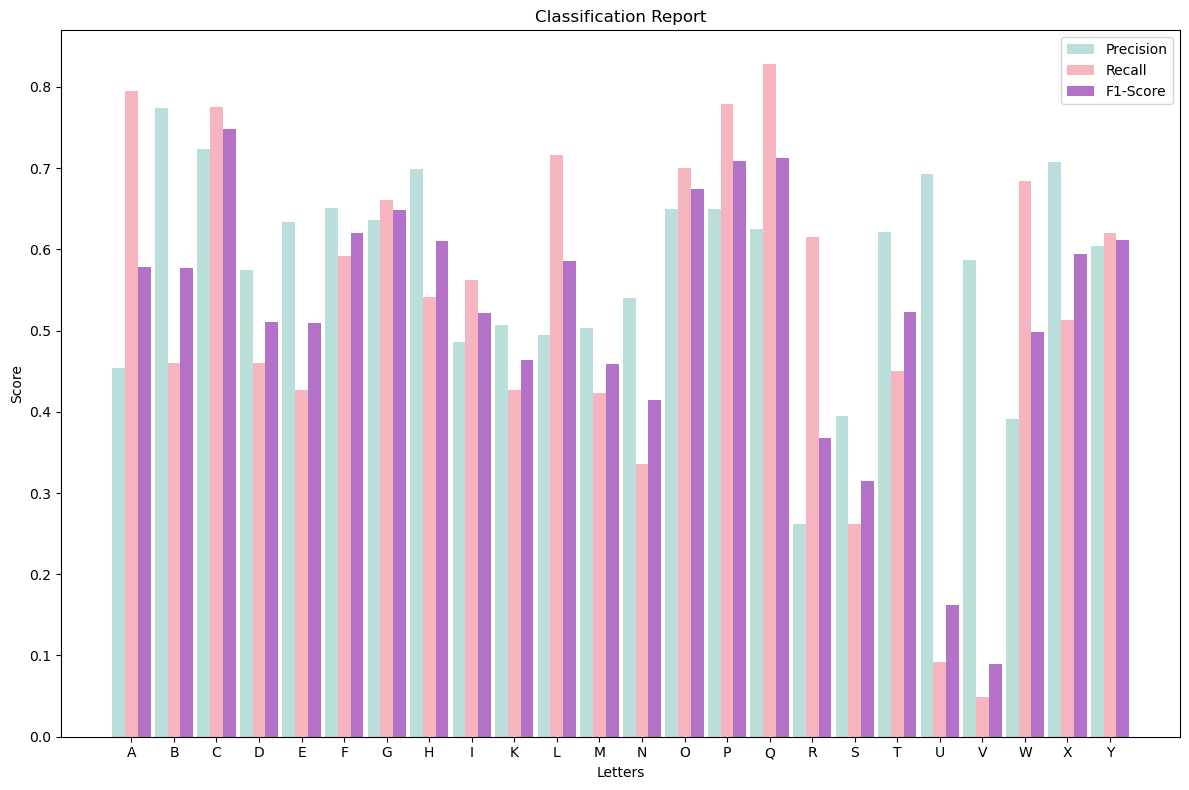

MCC: 0.5180986803161411
Cohen's Kappa: 0.5151415723255848


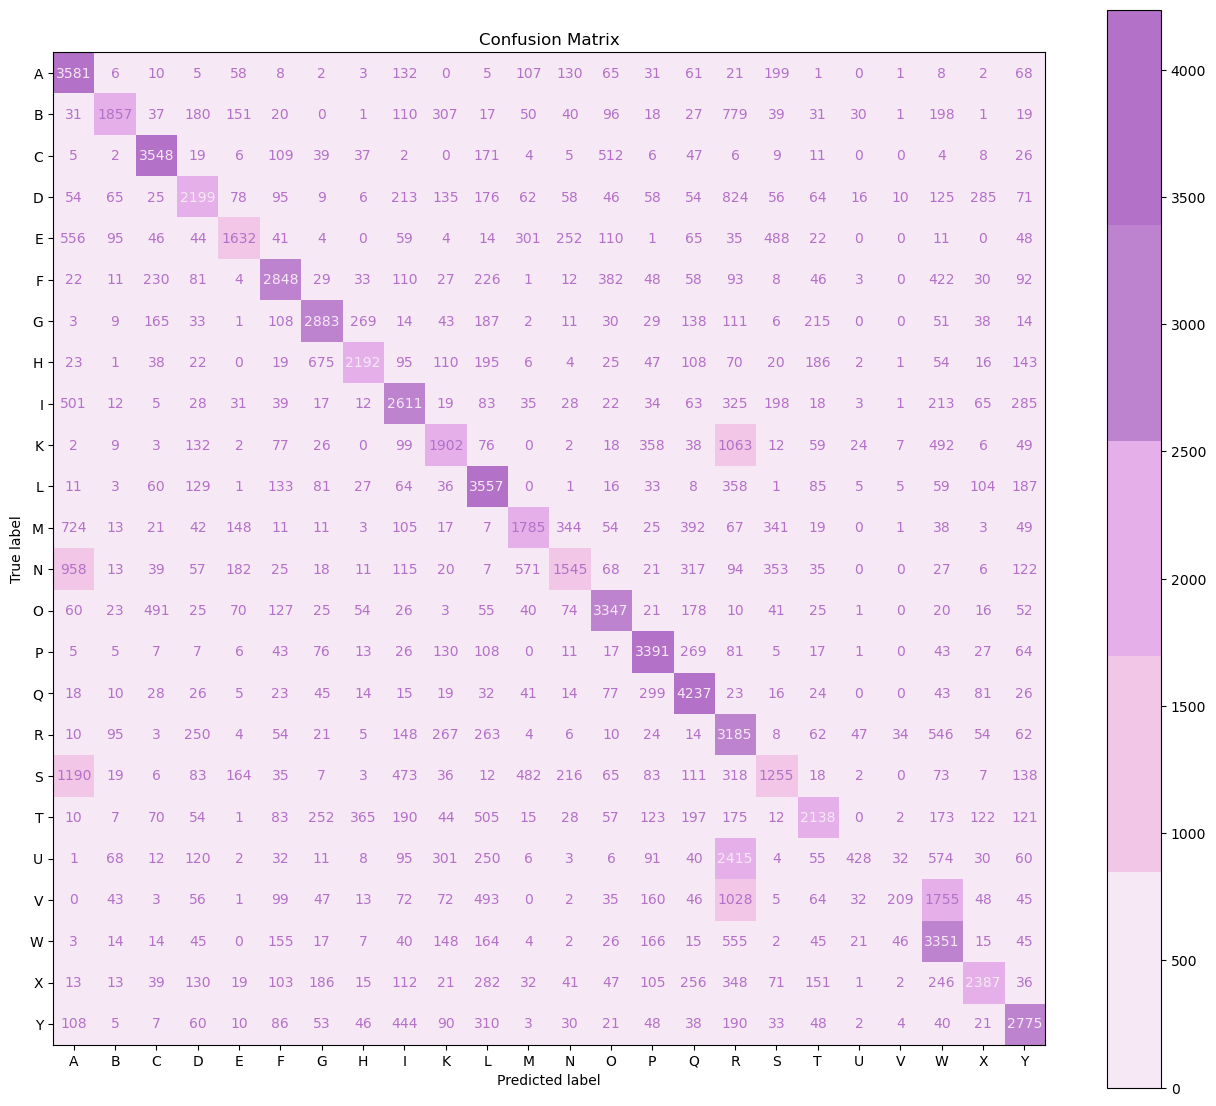

Accuracy: 0.4210122699386503
Classification report:
              precision    recall  f1-score   support

           A       0.39      0.77      0.52      1324
           B       0.81      0.34      0.48      1728
           C       0.71      0.66      0.68      1240
           D       0.39      0.38      0.39       980
           E       0.68      0.32      0.44      1992
           F       0.46      0.51      0.48       988
           G       0.54      0.50      0.52      1392
           H       0.78      0.45      0.57      1744
           I       0.39      0.43      0.41      1152
           K       0.30      0.25      0.28      1324
           L       0.38      0.79      0.51       836
           M       0.44      0.34      0.38      1576
           N       0.30      0.19      0.23      1164
           O       0.47      0.57      0.51       984
           P       0.71      0.76      0.73      1388
           Q       0.35      0.77      0.48       656
           R       0.12      

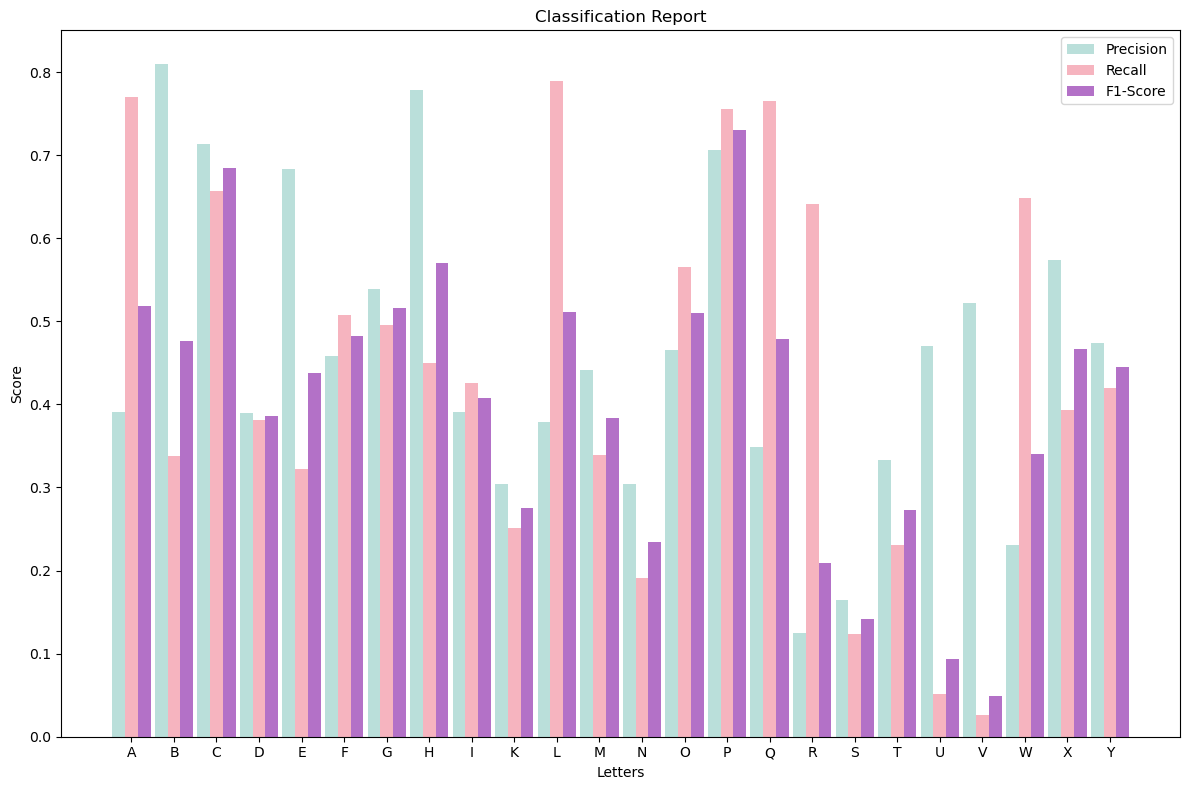

MCC: 0.4016037083169605
Cohen's Kappa: 0.3972766531870806


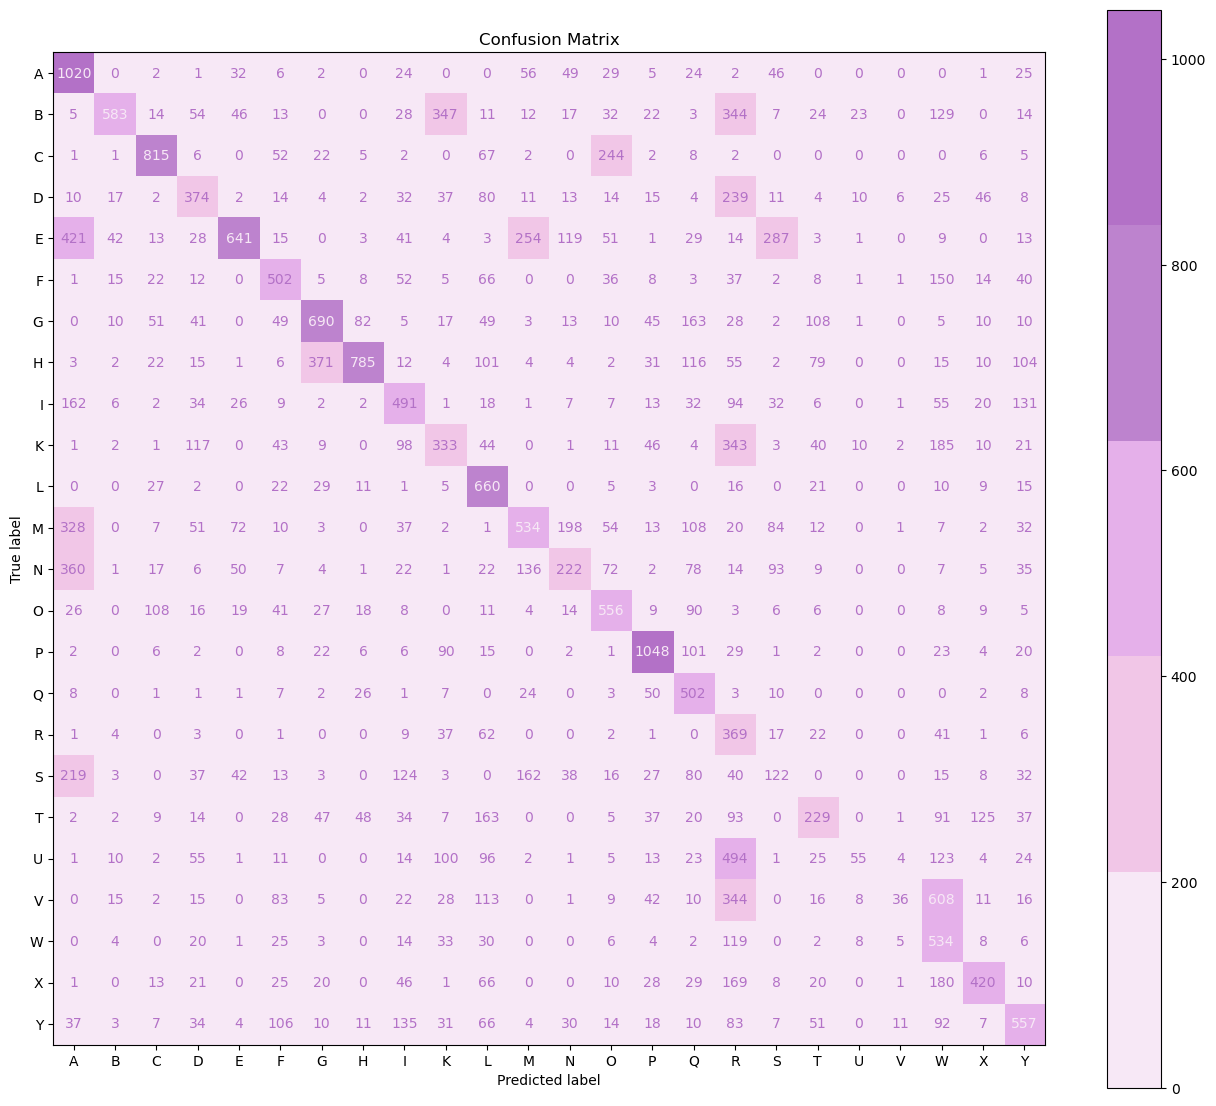

In [83]:
evaluate_model(y_train, y_pred_train, letters)
evaluate_model(y_test, y_pred_test, letters)


#### Deep Learning

In [ ]:
#data generation

import os

import cv2
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import math
import time

cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)

offset = 20
imgSize = 300


counter = 0

label = "Y"

folder = "../data/external/Data/" + label + "/"
if not os.path.exists(folder):
    os.makedirs(folder)
    print(f"Directory '{folder}' created successfully")
else:
    print(f"Directory '{folder}' already exists")

while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        imgCropShape = imgCrop.shape

        aspectRatio = h / w

        if aspectRatio > 1:
            k = imgSize / h
            wCal = math.ceil(k * w)
            imgResize = cv2.resize(imgCrop, (wCal, imgSize))
            imgResizeShape = imgResize.shape
            wGap = math.ceil((imgSize - wCal) / 2)
            imgWhite[:, wGap:wCal + wGap] = imgResize

        else:
            k = imgSize / w
            hCal = math.ceil(k * h)
            imgResize = cv2.resize(imgCrop, (imgSize, hCal))
            imgResizeShape = imgResize.shape
            hGap = math.ceil((imgSize - hCal) / 2)
            imgWhite[hGap:hCal + hGap, :] = imgResize

        cv2.imshow("ImageCrop", imgCrop)
        cv2.imshow("ImageWhite", imgWhite)

    cv2.imshow("Image", img)
    key = cv2.waitKey(1)
    if key == ord("s"):
        counter += 1
        cv2.imwrite(f'{folder}/Image_{time.time()}.jpg', imgWhite)
        print(counter)

In [ ]:
#training data

import tensorflow as tf
from tensorflow.keras import layers, models

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory='../data/external/Data/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    directory='../data/external/TestData/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    directory='../data/external/TestData/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=2,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size)

model.save('../data/external/my_cnn_model_updated.h5')

<img src="../data/external/model_summary.png" alt="Image Title" width="300" height="10">

In [ ]:
#Deep Learning Evaluation
from sklearn.metrics import classification_report

#training Data
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_generator)
# Generate predictions on the test set
predictions = model.predict(val_generator)
predicted_labels = tf.argmax(predictions, axis=1)
# Get the true labels
true_labels = val_generator.classes
# Get the class names
class_names = list(val_generator.class_indices.keys())
# Generate the classification report
evaluate_model(true_labels, predicted_labels.numpy(), class_names)


#testing Data
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(train_generator)
# Generate predictions on the test set
predictions = model.predict(train_generator)
predicted_labels = tf.argmax(predictions, axis=1)
# Get the true labels
true_labels = train_generator.classes
# Get the class names
class_names = list(train_generator.class_indices.keys())
# Generate the classification report
evaluate_model(true_labels, predicted_labels.numpy(), class_names)


## Attribution <a class="anchor" id="attribution"></a>

## Bibliography <a class="anchor" id="bibliography"></a>

## Appendix <a class="anchor" id="appendix"></a>

#### A. Naive Bayes Initial Results <a class="anchor" id="#a-naive-bayes-initial-results"></a>

The below code is used to train a Gaussian Naive Bayes model on the normalized training data. Once the model is trained, the evaluate_model() function is used to output the evaluation metrics described in the Methods section above. 

In [38]:
# Defining Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_norm, y_train)

# applying NB on normalized train data
y_pred_train = gnb.predict(X_train_norm)

# applying NB on normalized test data
y_pred_test = gnb.predict(X_test_norm)

Accuracy: 0.4600254962666181
Classification report:
              precision    recall  f1-score   support

           A       0.75      0.47      0.58      1126
           B       0.89      0.47      0.61      1010
           C       0.91      0.76      0.83      1144
           D       0.65      0.44      0.52      1196
           E       0.44      0.67      0.53       957
           F       0.52      0.36      0.42      1204
           G       0.68      0.58      0.63      1090
           H       0.61      0.42      0.50      1013
           I       0.37      0.66      0.48      1162
           K       0.30      0.49      0.37      1114
           L       0.68      0.57      0.62      1241
           M       0.44      0.36      0.39      1055
           N       0.50      0.26      0.34      1151
           O       0.56      0.62      0.59      1196
           P       0.33      0.74      0.45      1088
           Q       0.49      0.54      0.52      1279
           R       0.26      

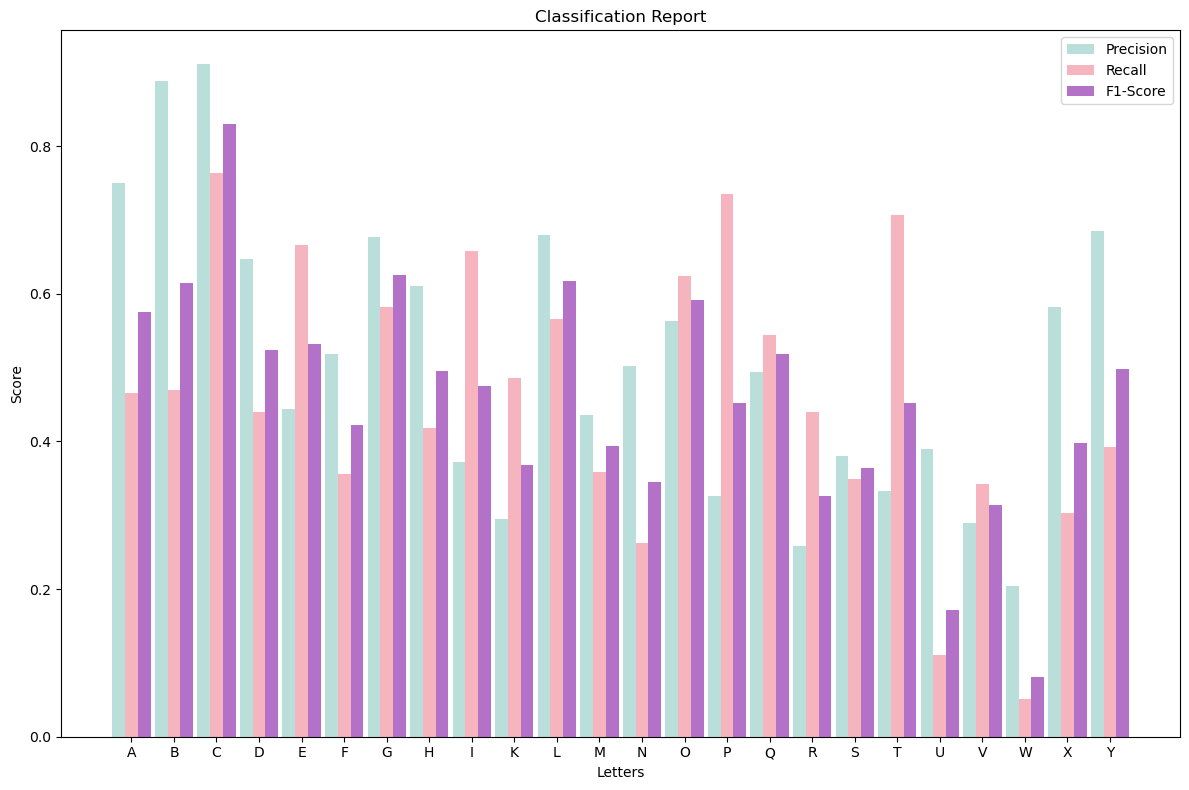

MCC: 0.4392833743318951
Cohen's Kappa: 0.4364137376183579


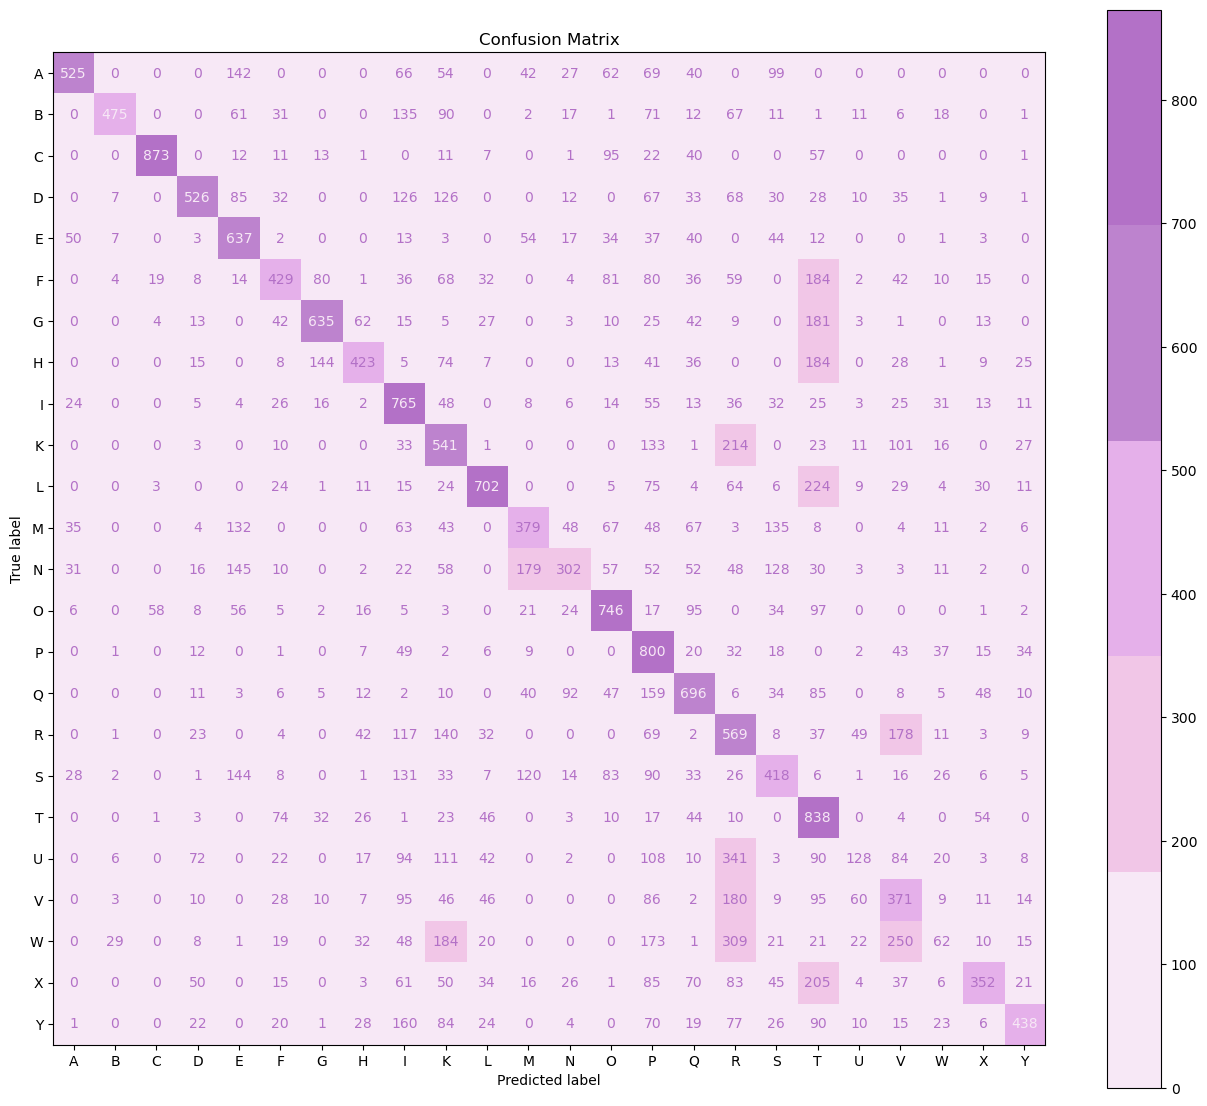

Accuracy: 0.3898494143892917
Classification report:
              precision    recall  f1-score   support

           A       0.71      0.48      0.57       331
           B       0.96      0.40      0.56       432
           C       0.72      0.50      0.59       310
           D       0.60      0.40      0.48       245
           E       0.53      0.56      0.55       498
           F       0.39      0.26      0.31       247
           G       0.54      0.56      0.55       348
           H       0.85      0.39      0.53       436
           I       0.22      0.45      0.30       288
           K       0.27      0.41      0.33       331
           L       0.41      0.45      0.43       209
           M       0.37      0.19      0.25       394
           N       0.38      0.31      0.34       291
           O       0.37      0.49      0.42       246
           P       0.43      0.81      0.56       347
           Q       0.29      0.60      0.39       164
           R       0.13      

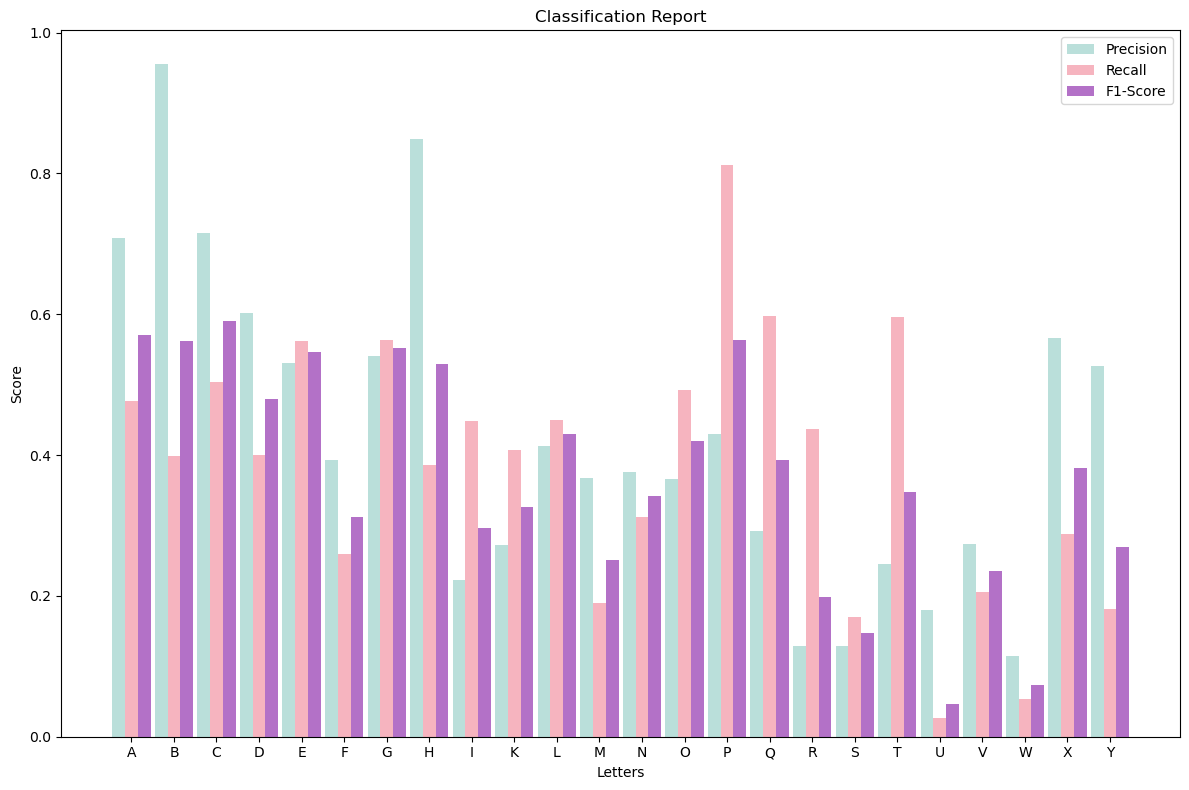

MCC: 0.36615100879087953
Cohen's Kappa: 0.36306888046227415


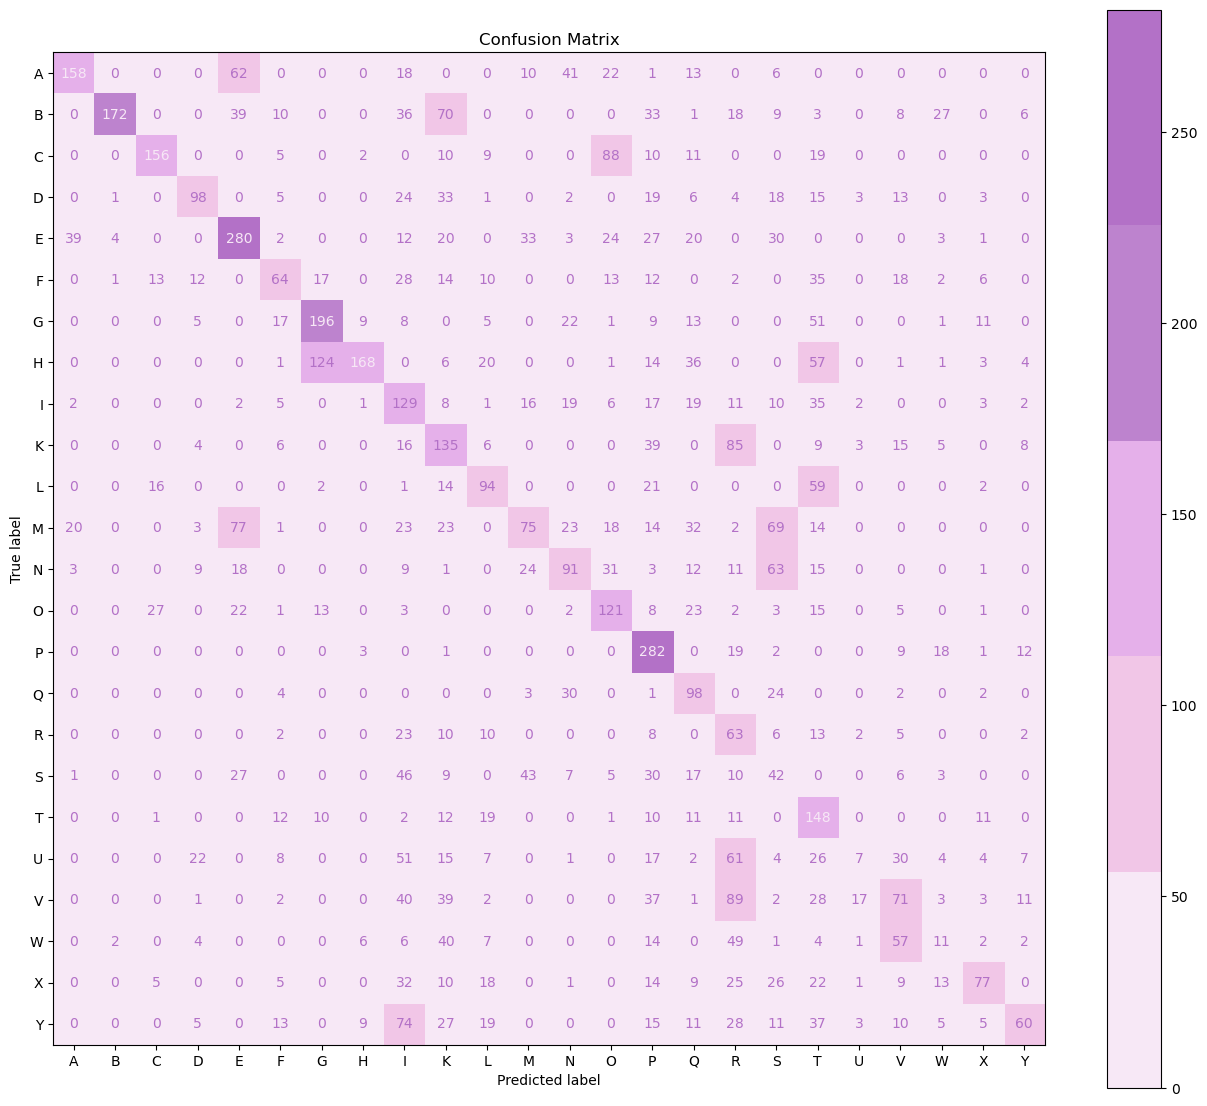

In [39]:
# Evaluating on train set
evaluate_model(y_train, y_pred_train, letters)

# Evaluating on test set
evaluate_model(y_test, y_pred_test, letters)

The results indicate that the Naive Bayes classifier is showing signs of overfitting. The high training accuracy (0.46) compared to the lower test accuracy (0.39) suggests that the model has learned the training data too well, resulting in poor generalization to unseen data. 

#### B. Logistic Regression Initial Results <a class="anchor" id="b-logistic-regression-initial-results"></a>

The below code describes the process of training the best Logistic Regression model, where Randomized Grid Search CV is used for hyperparameter tuning. The best parameters found using Randomized Grid Search CV are as follows:

Best hyperparameters: {'C': 3.4647045830997407, 'max_iter': 3171, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': False}

In [31]:
lr = LogisticRegression(C=3.4647045830997407,
                        max_iter=3171, 
                        penalty="l2", 
                        solver="liblinear",
                        warm_start=False)

lr.fit(X_train_norm, y_train)

# applying Logistic regression on train
y_pred_lr_train = lr.predict(X_train_norm)

# applying Logistic regression on test
y_pred_lr_test = lr.predict(X_test_norm)

LogisticRegression(C=3.4647045830997407, max_iter=3171, solver='liblinear')

Accuracy: 0.999745037333819
Classification report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1126
           B       1.00      1.00      1.00      1010
           C       1.00      1.00      1.00      1144
           D       1.00      1.00      1.00      1196
           E       1.00      1.00      1.00       957
           F       1.00      1.00      1.00      1204
           G       1.00      1.00      1.00      1090
           H       1.00      1.00      1.00      1013
           I       1.00      1.00      1.00      1162
           K       1.00      1.00      1.00      1114
           L       1.00      1.00      1.00      1241
           M       1.00      1.00      1.00      1055
           N       1.00      1.00      1.00      1151
           O       1.00      1.00      1.00      1196
           P       1.00      1.00      1.00      1088
           Q       1.00      1.00      1.00      1279
           R       1.00      1

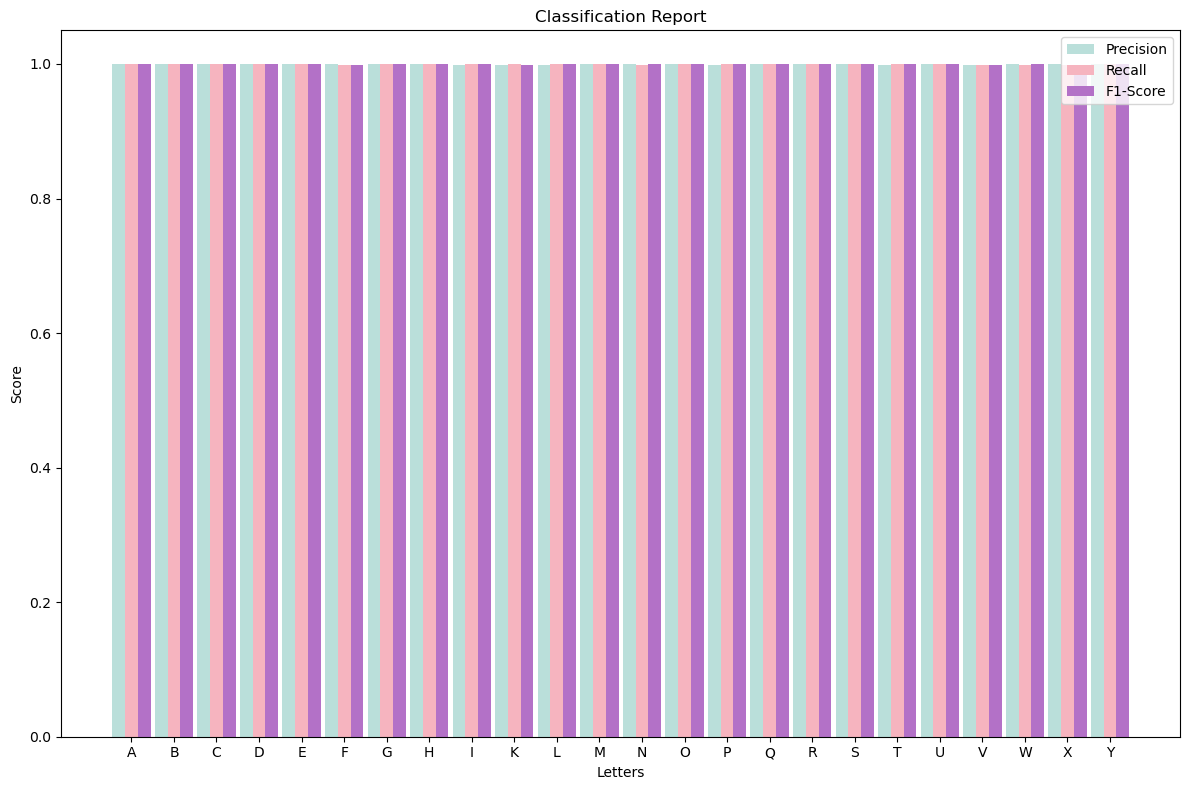

MCC: 0.9997339050943962
Cohen's Kappa: 0.9997338926358993


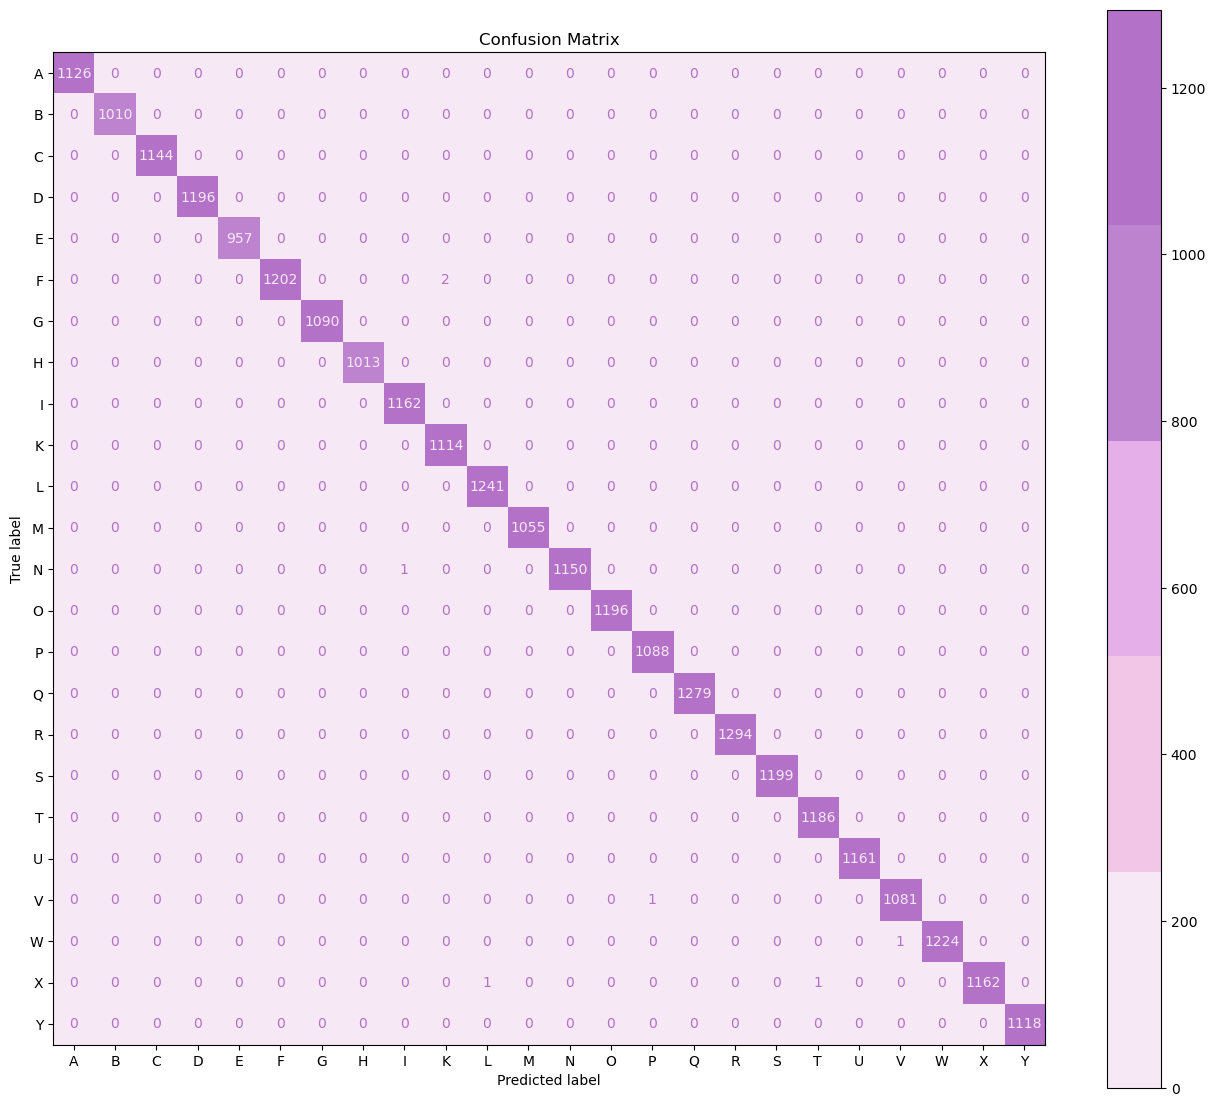

Accuracy: 0.6692693809258227
Classification report:
              precision    recall  f1-score   support

           A       0.83      0.94      0.89       331
           B       1.00      0.83      0.90       432
           C       0.93      0.86      0.89       310
           D       0.79      0.90      0.84       245
           E       0.80      0.88      0.84       498
           F       0.63      0.90      0.74       247
           G       0.72      0.81      0.76       348
           H       0.84      0.71      0.77       436
           I       0.71      0.57      0.63       288
           K       0.63      0.37      0.46       331
           L       0.78      0.90      0.84       209
           M       0.69      0.49      0.58       394
           N       0.57      0.44      0.50       291
           O       1.00      0.59      0.74       246
           P       0.79      0.79      0.79       347
           Q       0.58      0.74      0.65       164
           R       0.19      

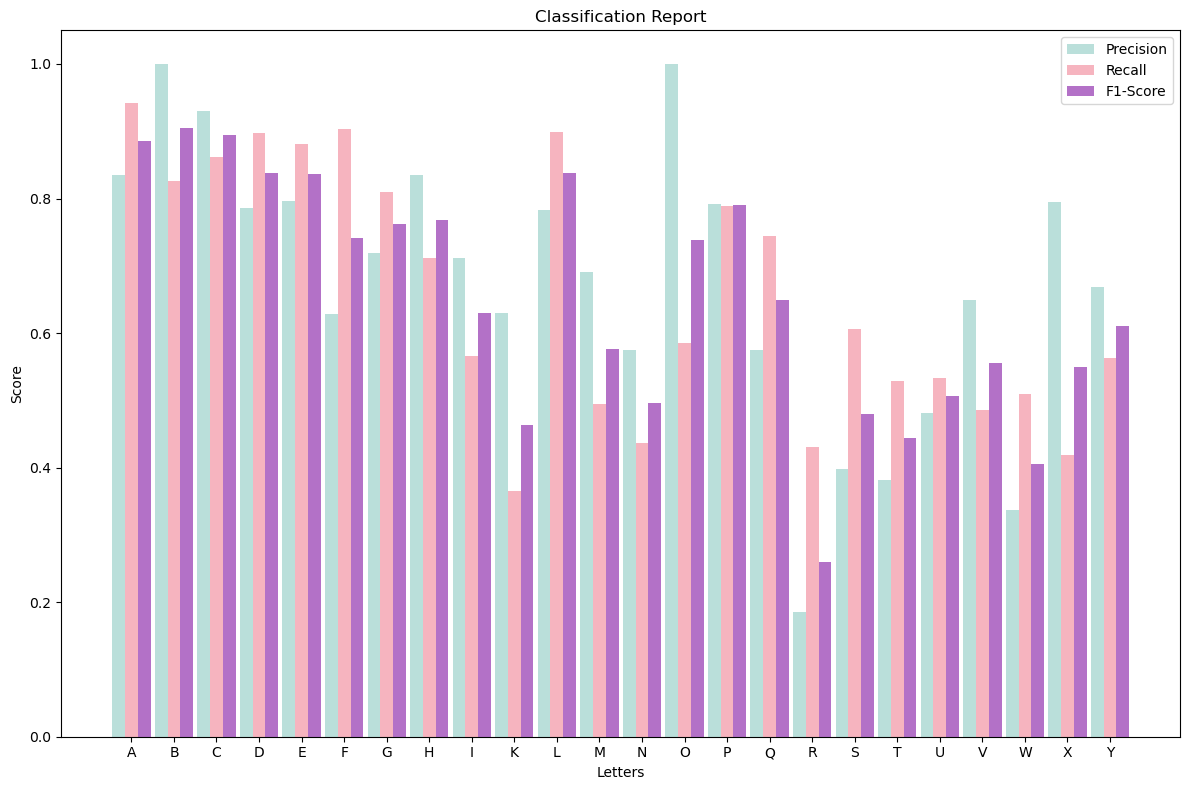

MCC: 0.6555084229826728
Cohen's Kappa: 0.6542843992274351


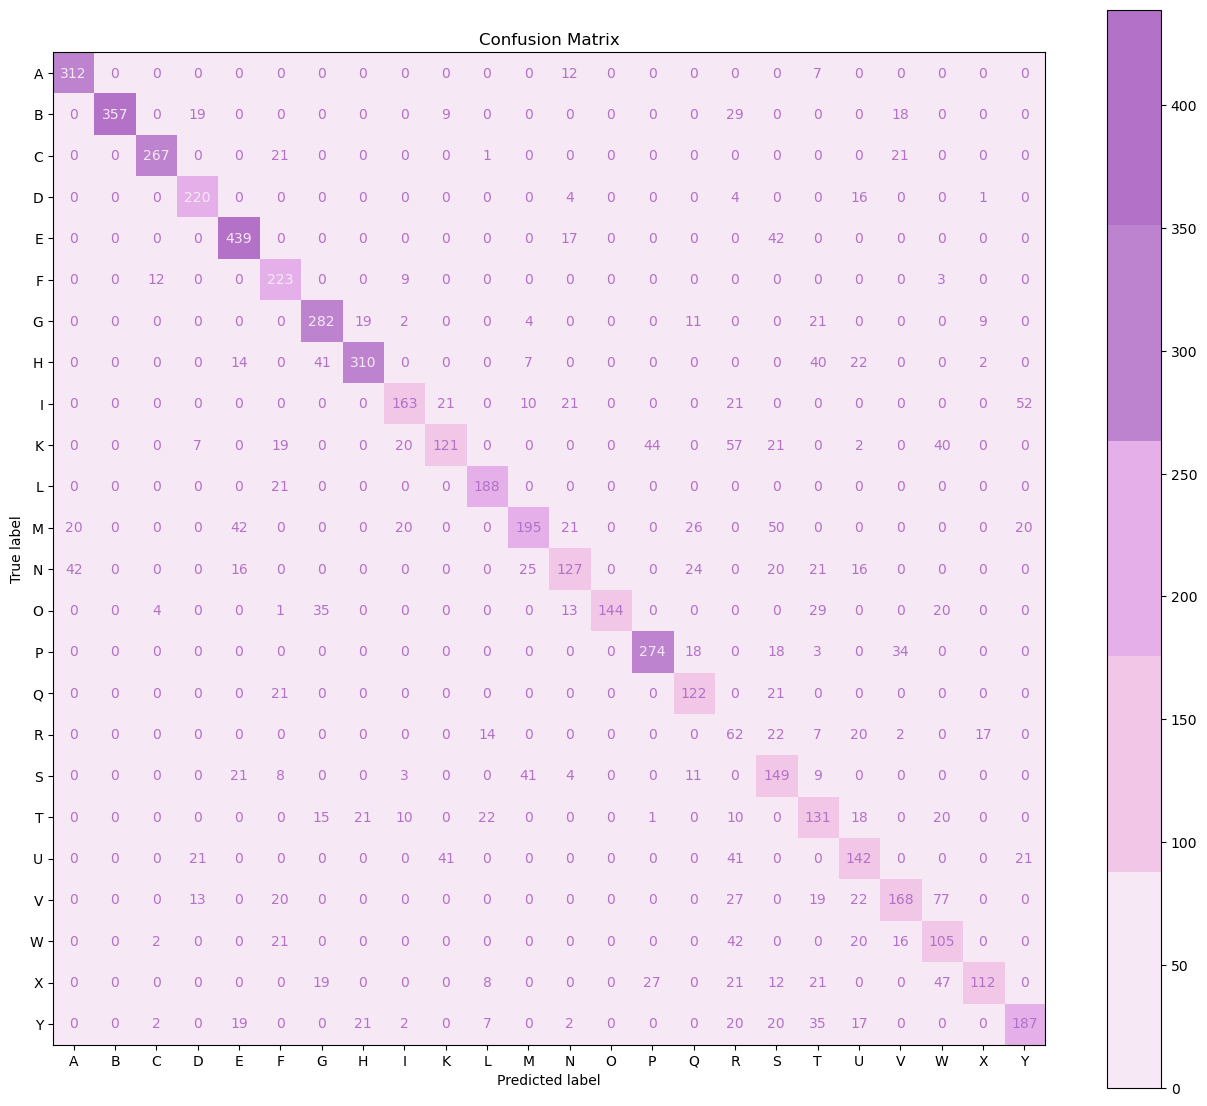

In [40]:
evaluate_model(y_train, y_pred_lr_train, letters)
evaluate_model(y_test, y_pred_lr_test, letters)

As seen in the train vs test evaluation, the Logistic Regression model on the 27k training images results in overfitting. The train accuracy is 100%, while the test accuracy is 67%. This indicates that techniques like data augmentation, regularization, and dimensionality reduction are needed to reduce the liklihood of overfitting. 

Feature Selection
* UMAP, SVD, TSNE

Main Model Results not with combined features

In [86]:
# Normalizing the data
#X_train_norm = X_train/255
#X_test_norm = X_test/255
# Print the shapes of the augmented data
print(f'X_train shape: {X_train_norm.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test_norm.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (109820, 784)
y_train shape: (109820,)
X_test shape: (28688, 784)
y_test shape: (28688,)


### SVD

In [93]:
n_components = 10
svd = TruncatedSVD(n_components, n_iter=7, random_state=42)

# Build the pipeline
pipe = Pipeline([('reducer', svd)])

# Fit the pipeline to X_train_sc and transform the data
X_train_svd = pipe.fit_transform(X_train_norm)

X_test_svd = svd.transform(X_test_norm)

In [94]:
# calculate the explained variance ratio for each component
explained_variance_ratio = svd.explained_variance_ratio_
explained_variance_ratio

array([0.57801598, 0.06165046, 0.04856357, 0.03330968, 0.02285816,
       0.01864049, 0.01758379, 0.0155315 , 0.01323109, 0.01095916])

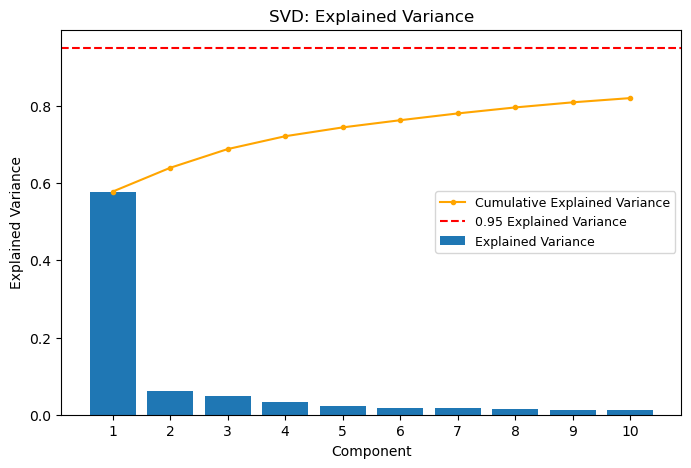

In [95]:
# Getting explained variance ratio from the lda model 
evr = svd.explained_variance_ratio_
components = range(1, len(evr) + 1)

# Plotting scree plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x=components, height=evr, label='Explained Variance')
plt.plot(components, np.cumsum(evr), marker='.', color='orange', label='Cumulative Explained Variance')
plt.axhline(y=.95, color='r', linestyle='--', label='0.95 Explained Variance')
plt.xticks(range(1, len(evr) + 1))
plt.title('SVD: Explained Variance')
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.legend(fontsize=9)

# Show the plot
plt.show()

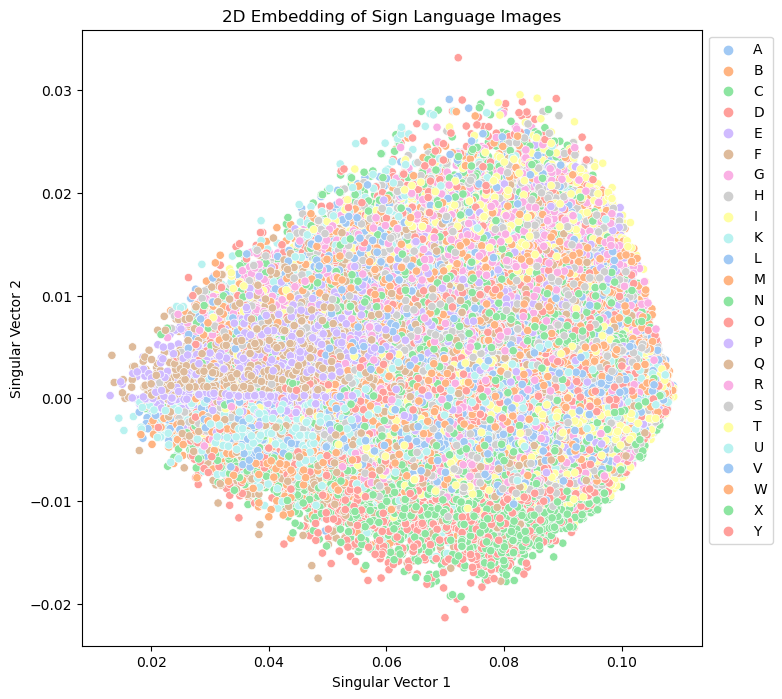

In [96]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_svd[:,0], y = X_train_svd[:,1], hue = y_train, palette = 'pastel');
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Singular Vector 1');
plt.ylabel('Singular Vector 2');

### TSN-E

In [99]:
# Initialize t-SNE object
tsne = TSNE(n_components=2, random_state=0 )
# Apply t-SNE to data
tsne_res = tsne.fit_transform(X_train_norm)

/var/folders/ph/_s861md14q5c2ykky6q5pgd80000gn/T/ipykernel_15778/1653652376.py:4: UserWarning: 
The palette list has fewer values (10) than needed (24) and will cycle, which may produce an uninterpretable plot.
  ax= sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_train, palette = sns.hls_palette(10), legend = 'full')


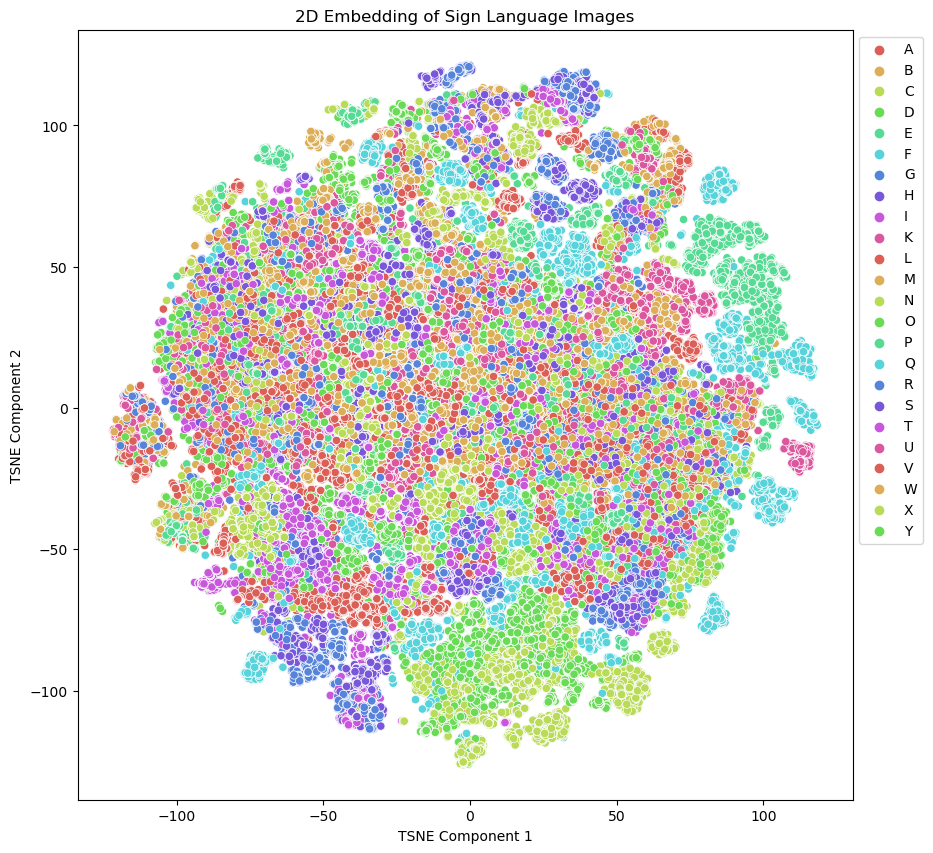

In [100]:
# Plot t-SNE results
fig, ax = plt.subplots(figsize = (10,10))

ax= sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_train, palette = sns.hls_palette(10), legend = 'full')
handler, _ = ax.get_legend_handles_labels();

plt.legend(handler, letters, bbox_to_anchor = (1, 1));
#title
plt.title('2D Embedding of Sign Language Images')
#x-axis label 
plt.xlabel('TSNE Component 1');
#y-axis label
plt.ylabel('TSNE Component 2');